# HEC-RAS 2D HDF Data Analysis Notebook

This notebook demonstrates how to manipulate and analyze HEC-RAS 2D HDF data using the ras-commander library. It leverages the HdfBase, HdfUtils, HdfStruc, HdfMesh, HdfXsec, HdfBndry, HdfPlan, HdfResultsPlan, HdfResultsMesh, and HdfResultsXsec classes to streamline data extraction, processing, and visualization.


In [1]:
# Install ras-commander from pip (uncomment to install if needed)
#!pip install ras-commander
# This installs ras-commander and all dependencies

In [2]:
# Import all required modules
from ras_commander import *  # Import all ras-commander modules

# Import the required libraries for this notebook
import h5py
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm
import scipy
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython import display
import psutil  # For getting system CPU info
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import subprocess
import sys
import os
import shutil
from datetime import datetime, timedelta
from pathlib import Path  # Ensure pathlib is imported for file operations
import rasterio
from rasterio.plot import show
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
import logging



In [3]:
# Download the BaldEagleCrkMulti2D project from HEC and Run Plan 06

# Define the path to the BaldEagleCrkMulti2D project
current_dir = Path.cwd()  # Adjust if your notebook is in a different directory
bald_eagle_path = current_dir / "example_projects" / "BaldEagleCrkMulti2D"
import logging

# Check if BaldEagleCrkMulti2D.p06.hdf exists (so we don't have to re-run the simulation when re-running or debugging)
hdf_file = bald_eagle_path / "BaldEagleDamBrk.p06.hdf"

if not hdf_file.exists():
    # Initialize RasExamples and extract the BaldEagleCrkMulti2D project
    RasExamples.extract_project(["BaldEagleCrkMulti2D"])

    # Initialize the RAS project using the default global ras object
    init_ras_project(bald_eagle_path, "6.6")
    logging.info(f"Bald Eagle project initialized with folder: {ras.project_folder}")
    
    logging.info(f"Bald Eagle object id: {id(ras)}")
    
    # Define the plan number to execute
    plan_number = "06"

    # Update run flags for the project
    RasPlan.update_run_flags(
        plan_number,
        geometry_preprocessor=True,
        unsteady_flow_simulation=True,
        run_sediment=False,
        post_processor=True,
        floodplain_mapping=False
    )

    # Execute Plan 06 using RasCmdr for Bald Eagle
    print(f"Executing Plan {plan_number} for the Bald Eagle Creek project...")
    success_bald_eagle = RasCmdr.compute_plan(plan_number)
    if success_bald_eagle:
        print(f"Plan {plan_number} executed successfully for Bald Eagle.\n")
    else:
        print(f"Plan {plan_number} execution failed for Bald Eagle.\n")
else:
    print("BaldEagleCrkMulti2D.p06.hdf already exists. Skipping project extraction and plan execution.")
    # Initialize the RAS project using the default global ras object
    init_ras_project(bald_eagle_path, "6.6")
    plan_number = "06"

2025-03-15 08:33:57 - ras_commander.RasExamples - INFO - Found zip file: c:\GH\ras-commander\examples\Example_Projects_6_6.zip
2025-03-15 08:33:57 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2025-03-15 08:33:57 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2025-03-15 08:33:57 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2025-03-15 08:33:57 - ras_commander.RasExamples - INFO - Extracting project 'BaldEagleCrkMulti2D'
2025-03-15 08:34:00 - ras_commander.RasExamples - INFO - Successfully extracted project 'BaldEagleCrkMulti2D' to c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D
2025-03-15 08:34:00 - ras_commander.RasPrj - INFO - Initializing global 'ras' object via init_ras_project function.
2025-03-15 08:34:01 - ras_commander.RasPrj - INFO - Project initialized. ras_object project folder: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D
2025-03-15 08:34:01 - root - INFO - Ba

Executing Plan 06 for the Bald Eagle Creek project...


2025-03-15 08:42:30 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 06
2025-03-15 08:42:30 - ras_commander.RasCmdr - INFO - Total run time for plan 06: 509.38 seconds


Plan 06 executed successfully for Bald Eagle.



In [4]:
# Load Plan and Geometry Dataframes and find Plan and Geometry HDF Paths

# Display plan_df for bald_eagle project
print("Plan DataFrame for bald_eagle project:")
ras.plan_df

# Display geom_df for bald_eagle project
print("\nGeometry DataFrame for bald_eagle project:")
ras.geom_df

# Get the plan HDF path
plan_number = "06"  # Assuming we're using plan 01 as in the previous code
plan_hdf_path = ras.plan_df.loc[ras.plan_df['plan_number'] == plan_number, 'HDF_Results_Path'].values[0]

# Get the geometry file number from the plan DataFrame
geom_file = ras.plan_df.loc[ras.plan_df['plan_number'] == plan_number, 'Geom File'].values[0]
geom_number = geom_file[1:]  # Remove the 'g' prefix

# Get the geometry HDF path
geom_hdf_path = ras.geom_df.loc[ras.geom_df['geom_number'] == geom_number, 'hdf_path'].values[0]

print(f"\nPlan HDF path for Plan {plan_number}: {plan_hdf_path}")
print(f"Geometry HDF path for Plan {plan_number}: {geom_hdf_path}")

Plan DataFrame for bald_eagle project:

Geometry DataFrame for bald_eagle project:

Plan HDF path for Plan 06: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
Geometry HDF path for Plan 06: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf


In [5]:
# Define the HDF input path as Plan Number

plan_number = "06"  # Assuming we're using plan 01 as in the previous code


RasHdfUtils
| Method Name | Description |
|-------------|-------------|
| get_attrs | Converts attributes from a HEC-RAS HDF file into a Python dictionary for a given attribute path |
| get_root_attrs | Returns attributes at root level of HEC-RAS HDF file |
| get_hdf_paths_with_properties | Gets all paths in the HDF file with their properties |
| get_group_attributes_as_df | Gets attributes of a group in the HDF file as a DataFrame |
| get_hdf_filename | Gets the HDF filename from various input types |
| get_runtime_data | Extracts runtime and compute time data from a single HDF file |


In [6]:
# Get HDF Paths with Properties (For Exploring HDF Files)
HdfBase.get_dataset_info(plan_number, group_path="/")

2025-03-15 08:42:30 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf



Exploring group: /


    Group: //Event Conditions
    Attributes for //Event Conditions:
        Completed Successfully: b'True'
        Date Processed: b'3/15/2025 8:34:58 AM'
        Group: //Event Conditions/Meteorology
            Dataset: //Event Conditions/Meteorology/Attributes
                Shape: (1,)
                Dtype: [('Variable', 'S32'), ('Group', 'S42')]
            Group: //Event Conditions/Meteorology/Precipitation
    Attributes for //Event Conditions/Meteorology/Precipitation:
        DSS Filename: b'.\\Precipitation\\precip.2018.09.dss'
        DSS Pathname: b'/SHG/MARFC/PRECIP/01SEP2018:0200/01SEP2018:0300/NEXRAD/'
        Data Type: b'per-cum'
        Interpolation Method: b''
        Mode: b'Gridded'
        Projection: b'PROJCS["USA_Contiguous_Albers_Equal_Area_Conic_USGS_version",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree

In [7]:
# Example: Extract runtime and compute time data
print("\nExample 2: Extracting runtime and compute time data")
runtime_df = HdfResultsPlan.get_runtime_data(hdf_input=plan_number)
if runtime_df is not None:
    runtime_df
else:
    print("No runtime data found.")

2025-03-15 08:42:31 - ras_commander.HdfResultsPlan - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:31 - ras_commander.HdfResultsPlan - INFO - Extracting Plan Information from: BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:31 - ras_commander.HdfResultsPlan - INFO - Plan Name: Gridded Precip - Infiltration
2025-03-15 08:42:31 - ras_commander.HdfResultsPlan - INFO - Simulation Duration (hours): 120.0



Example 2: Extracting runtime and compute time data


runtime_df example output: 

| Plan Name                        | File Name                     | Simulation Start Time | Simulation End Time | Simulation Duration (s) | Simulation Time (hr) | Completing Geometry (hr) | Preprocessing Geometry (hr) | Completing Event Conditions (hr) | Unsteady Flow Computations (hr) | Complete Process (hr) | Unsteady Flow Speed (hr/hr) | Complete Process Speed (hr/hr) |
|----------------------------------|-------------------------------|-----------------------|---------------------|-------------------------|-----------------------|--------------------------|------------------------------|----------------------------------|----------------------------------|-----------------------|------------------------------|----------------------------------|
| Gridded Precip - Infiltration    | BaldEagleDamBrk.p06.hdf      | 09Sep2018 00:00:00    | 14Sep2018 00:00:00  | 432000.0                | 120.0                 | N/A                      | 0.000113                     | N/A                              | 0.074436                        | 0.080951              | 1612.126776                  | 1482.386368                      |

Table of all the functions in the RasGeomHdf class from the ras_commander/RasGeomHdf.py file:

| Function Name | Description |
|---------------|-------------|
| projection | Returns the projection of the RAS geometry as a pyproj.CRS object |
| get_geom_attrs | Returns base geometry attributes from a HEC-RAS HDF file |

| mesh_area_names | Returns a list of the 2D mesh area names of the RAS geometry |
| get_geom_2d_flow_area_attrs | Returns geometry 2d flow area attributes from a HEC-RAS HDF file |
| mesh_areas | Returns 2D flow area perimeter polygons |
| mesh_cell_polygons | Returns 2D flow mesh cell polygons |
| mesh_cell_points | Returns 2D flow mesh cell points |
| mesh_cell_faces | Returns 2D flow mesh cell faces |

| get_geom_structures_attrs | Returns geometry structures attributes from a HEC-RAS HDF file |




| bc_lines | Returns 2D mesh area boundary condition lines |
| breaklines | Returns 2D mesh area breaklines |



| refinement_regions | Returns 2D mesh area refinement regions |
| structures | Returns the model structures |
| reference_lines_names | Returns reference line names |
| reference_points_names | Returns reference point names |
| reference_lines | Returns the reference lines geometry and attributes |
| reference_points | Returns the reference points geometry and attributes |
| cross_sections | Returns the model 1D cross sections |
| river_reaches | Returns the model 1D river reach lines |
| cross_sections_elevations | Returns the model cross section elevation information |

In [8]:
# For all of the RasGeomHdf Class Functions, we will use geom_hdf_path
print(geom_hdf_path)

# For the example project, plan 06 is associated with geometry 09
# If you want to call the geometry by number, call RasHdfGeom functions with a number
# Otherwise, if you want to look up geometry hdf path by plan number, follow the logic in the previous code cells

c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf


In [9]:
# Use HdfUtils for extracting projection
print("\nExtracting Projection from HDF")
projection = HdfBase.get_projection(hdf_path=geom_hdf_path)
if projection:
    print(f"Projection: {projection}")
else:
    print("No projection information found.")

2025-03-15 08:42:31 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:31 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf



Extracting Projection from HDF
Projection: PROJCS["NAD_1983_StatePlane_Pennsylvania_North_FIPS_3701_Feet",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic"],PARAMETER["False_Easting",1968500.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-77.75],PARAMETER["Standard_Parallel_1",40.88333333333333],PARAMETER["Standard_Parallel_2",41.95],PARAMETER["Latitude_Of_Origin",40.16666666666666],UNIT["Foot_US",0.3048006096012192]]


In [10]:
# Use HdfPlan for geometry-related operations
print("\nExample: Extracting Geometry Information")
geom_attrs = HdfPlan.get_geometry_information(geom_hdf_path)
geom_attrs


2025-03-15 08:42:31 - ras_commander.HdfPlan - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf



Example: Extracting Geometry Information
Getting geometry attributes from c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
Checking for Geometry group in c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
Getting root level geometry attributes
Successfully extracted root level geometry attributes


,Value
Complete Geometry,True
Extents,"[1960041.35636708, 2092643.59732271, 285497.89..."
Geometry Time,2025-03-15 08:33:58
Infiltration Date Last Modified,2022-03-11 13:52:44
Infiltration File Date,2020-11-24 13:24:58
Infiltration Filename,.\Soils Data\Infiltration.hdf
Infiltration Layername,Infiltration
Land Cover Date Last Modified,2022-03-11 13:45:08
Land Cover File Date,2022-03-11 13:45:08
Land Cover Filename,.\Land Classification\LandCover.hdf


geom_attrs output: 

| Complete Geometry | Extents | Geometry Time | Infiltration Date Last Modified | Infiltration File Date | Infiltration Filename | Infiltration Layername | Land Cover Date Last Modified | Land Cover File Date | Land Cover Filename | ... | Percent Impervious Date Last Modified | Percent Impervious File Date | Percent Impervious Filename | Percent Impervious Layername | SI Units | Terrain File Date | Terrain Filename | Terrain Layername | Title | Version |
|-------------------|---------|---------------|---------------------------------|-----------------------|----------------------|------------------------|------------------------------|----------------------|---------------------|-----|--------------------------------------|-----------------------------|----------------------------|------------------------------|----------|-------------------|------------------|-------------------|-------|---------|
| 0                 | True    | [1960041.35636708, 2092643.59732271, 285497.89...] | 27Oct2024 20:09:19 | 11MAR2022 13:52:44 | 24NOV2020 13:24:58 | .\Soils Data\Infiltration.hdf | Infiltration | 11MAR2022 13:45:08 | 11MAR2022 13:45:08 | .\Land Classification\LandCover.hdf | ... | 11MAR2022 13:45:08 | 11MAR2022 13:45:08 | .\Land Classification\LandCover.hdf | LandCover | False | 09FEB2015 08:26:58 | .\Terrain\Terrain50.hdf | Terrain50 | Single 2D Area - Internal Dam Structure | 1.0.20 (20Sep2024) |

In [11]:
# Use HdfMesh for geometry-related operations
print("\nExample 3: Listing 2D Flow Area Names")
flow_area_names = HdfMesh.get_mesh_area_names(geom_hdf_path)
print("2D Flow Area Name (returned as list):\n", flow_area_names)
# Note: this is returned as a list because it is used internally by other functions.  

2025-03-15 08:42:31 - ras_commander.HdfMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf



Example 3: Listing 2D Flow Area Names
2D Flow Area Name (returned as list):
 ['BaldEagleCr']


In [12]:
# Example: Get 2D Flow Area Attributes (get_mesh_area_attributes)
print("\nExample: Extracting 2D Flow Area Attributes")
flow_area_attributes = HdfMesh.get_mesh_area_attributes(geom_hdf_path)
flow_area_attributes


Example: Extracting 2D Flow Area Attributes


2025-03-15 08:42:31 - ras_commander.HdfMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf


,Value
Name,b'BaldEagleCr'
Locked,0
Mann,0.04
Multiple Face Mann n,0
Composite LC,0
Cell Vol Tol,0.01
Cell Min Area Fraction,0.01
Face Profile Tol,0.01
Face Area Tol,0.01
Face Conv Ratio,0.02


flow_area_df:

Value
| Name                        | b'BaldEagleCr' |
|-----------------------------|-----------------|
| Locked                      | 0               |
| Mann                        | 0.04            |
| Multiple Face Mann n       | 0               |
| Composite LC               | 0               |
| Cell Vol Tol               | 0.01            |
| Cell Min Area Fraction      | 0.01            |
| Face Profile Tol           | 0.01            |
| Face Area Tol              | 0.01            |
| Face Conv Ratio            | 0.02            |
| Laminar Depth              | 0.2             |
| Min Face Length Ratio      | 0.05            |
| Spacing dx                 | 250.0           |
| Spacing dy                 | 250.0           |
| Shift dx                   | NaN             |
| Shift dy                   | NaN             |
| Cell Count                 | 18066           |

2025-03-15 08:42:31 - ras_commander.HdfMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:31 - ras_commander.HdfMesh - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:31 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:31 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf



Example: Extracting 2D Flow Area Perimeter Polygons


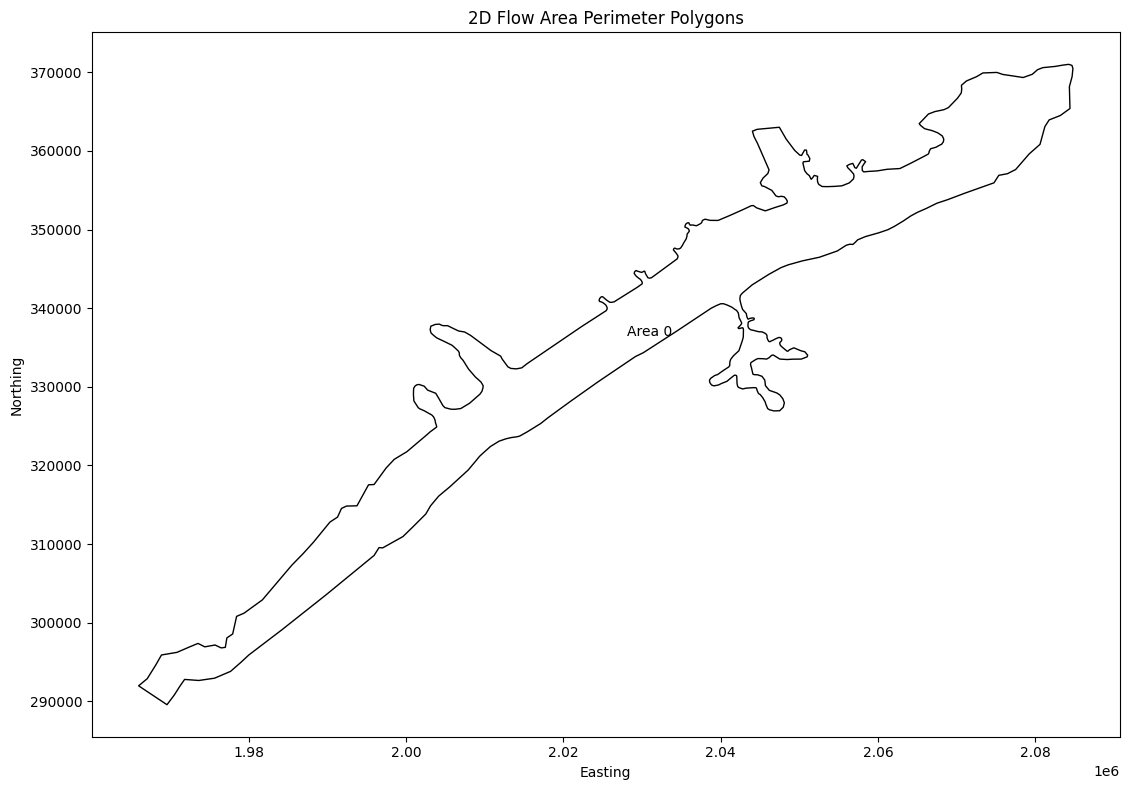

In [13]:
# Example: Get 2D Flow Area Perimeter Polygons (get_mesh_areas)
print("\nExample: Extracting 2D Flow Area Perimeter Polygons")
mesh_areas = HdfMesh.get_mesh_areas(geom_hdf_path)

# Plot the 2D Flow Area Perimeter Polygons
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
mesh_areas.plot(ax=ax, edgecolor='black', facecolor='none')

# Add labels for each polygon
for idx, row in mesh_areas.iterrows():
    centroid = row.geometry.centroid
    # Check if 'Name' column exists, otherwise use a default label
    label = row.get('Name', f'Area {idx}')
    ax.annotate(label, (centroid.x, centroid.y), ha='center', va='center')

plt.title('2D Flow Area Perimeter Polygons')
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.tight_layout()
plt.show()

In [14]:
# Example: Extract mesh cell faces
print("\nExample: Extracting mesh cell faces")

# Get mesh cell faces
mesh_cell_faces = HdfMesh.get_mesh_cell_faces(geom_hdf_path)

# Display the first few rows of the mesh cell faces DataFrame
print("First few rows of mesh cell faces:")
mesh_cell_faces.head()

2025-03-15 08:42:31 - ras_commander.HdfMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:31 - ras_commander.HdfMesh - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf



Example: Extracting mesh cell faces


2025-03-15 08:42:32 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:32 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf


First few rows of mesh cell faces:


,mesh_name,face_id,geometry
0,BaldEagleCr,0,"LINESTRING (2042125 351625, 2042375 351625)"
1,BaldEagleCr,1,"LINESTRING (2042375 351625, 2042375 351875)"
2,BaldEagleCr,2,"LINESTRING (2042375 351875, 2042125 351875)"
3,BaldEagleCr,3,"LINESTRING (2042125 351875, 2042125 351625)"
4,BaldEagleCr,4,"LINESTRING (2042375 351375, 2042375 351625)"


mesh_cell_faces geodataframe:

flow_area_df:

| mesh_name    | face_id | geometry                                           |
|--------------|---------|----------------------------------------------------|
| BaldEagleCr  | 0       | LINESTRING (2042125 351625, 2042375 351625)      |
| BaldEagleCr  | 1       | LINESTRING (2042375 351625, 2042375 351875)      |
| BaldEagleCr  | 2       | LINESTRING (2042375 351875, 2042125 351875)      |
| BaldEagleCr  | 3       | LINESTRING (2042125 351875, 2042125 351625)      |
| BaldEagleCr  | 4       | LINESTRING (2042375 351375, 2042375 351625)      |

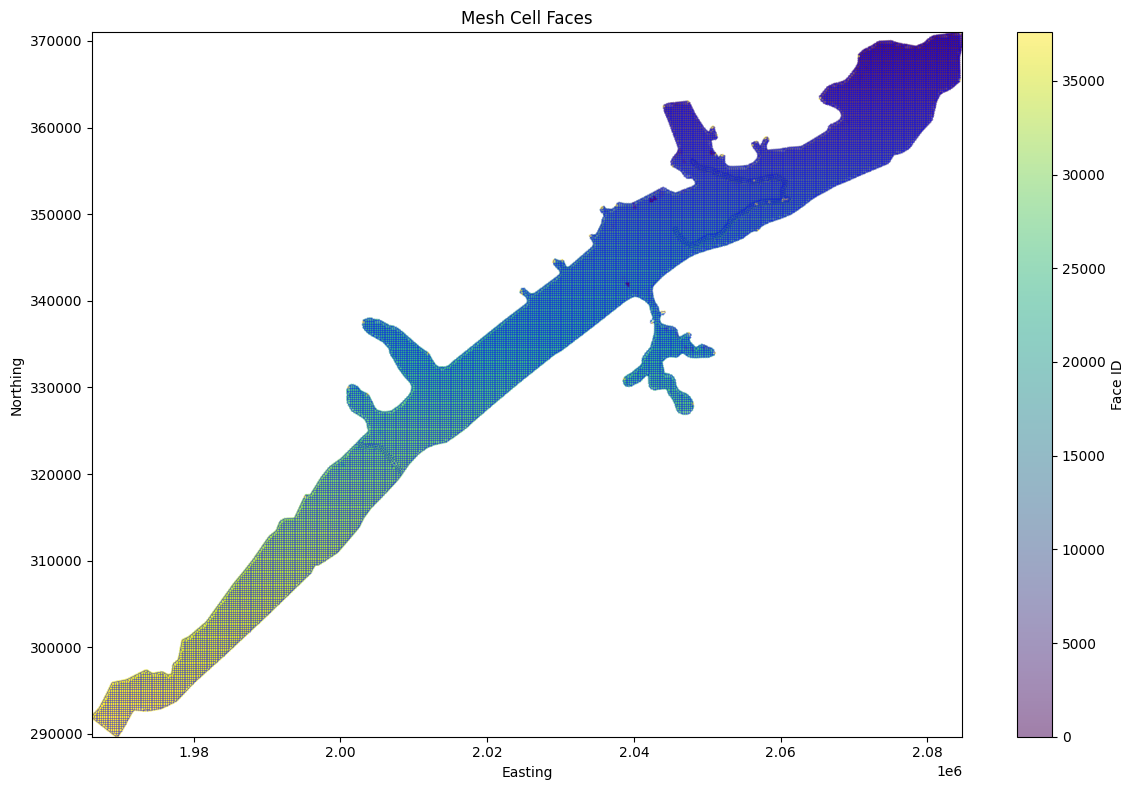


Mesh Cell Faces Statistics:
Total number of cell faces: 37594
Number of unique meshes: 1


In [15]:
from matplotlib.collections import LineCollection
import numpy as np

# Plot the mesh cell faces more efficiently
fig, ax = plt.subplots(figsize=(12, 8))

# Convert all geometries to numpy arrays at once for faster plotting
lines = [list(zip(*line.xy)) for line in mesh_cell_faces.geometry]
lines_collection = LineCollection(lines, colors='blue', linewidth=0.5, alpha=0.5)
ax.add_collection(lines_collection)

# Set plot title and labels
plt.title('Mesh Cell Faces')
plt.xlabel('Easting')
plt.ylabel('Northing')

# Calculate centroids once and store as numpy arrays
centroids = np.array([[geom.centroid.x, geom.centroid.y] for geom in mesh_cell_faces.geometry])

# Create scatter plot with numpy arrays
scatter = ax.scatter(
    centroids[:, 0],
    centroids[:, 1], 
    c=mesh_cell_faces['face_id'],
    cmap='viridis',
    s=1,
    alpha=0.5
)
plt.colorbar(scatter, label='Face ID')

# Set axis limits based on data bounds
ax.set_xlim(centroids[:, 0].min(), centroids[:, 0].max())
ax.set_ylim(centroids[:, 1].min(), centroids[:, 1].max())

plt.tight_layout()
plt.show()

# Calculate and display some statistics
print("\nMesh Cell Faces Statistics:")
print(f"Total number of cell faces: {len(mesh_cell_faces)}")
print(f"Number of unique meshes: {mesh_cell_faces['mesh_name'].nunique()}")



Example: Finding the nearest cell face to a given point
Using projection: PROJCS["NAD_1983_StatePlane_Pennsylvania_North_FIPS_3701_Feet",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic"],PARAMETER["False_Easting",1968500.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-77.75],PARAMETER["Standard_Parallel_1",40.88333333333333],PARAMETER["Standard_Parallel_2",41.95],PARAMETER["Latitude_Of_Origin",40.16666666666666],UNIT["Foot_US",0.3048006096012192]]
Nearest cell face to point (2042250.0, 351750.0):
Face ID: 0
Distance: 125.00 units


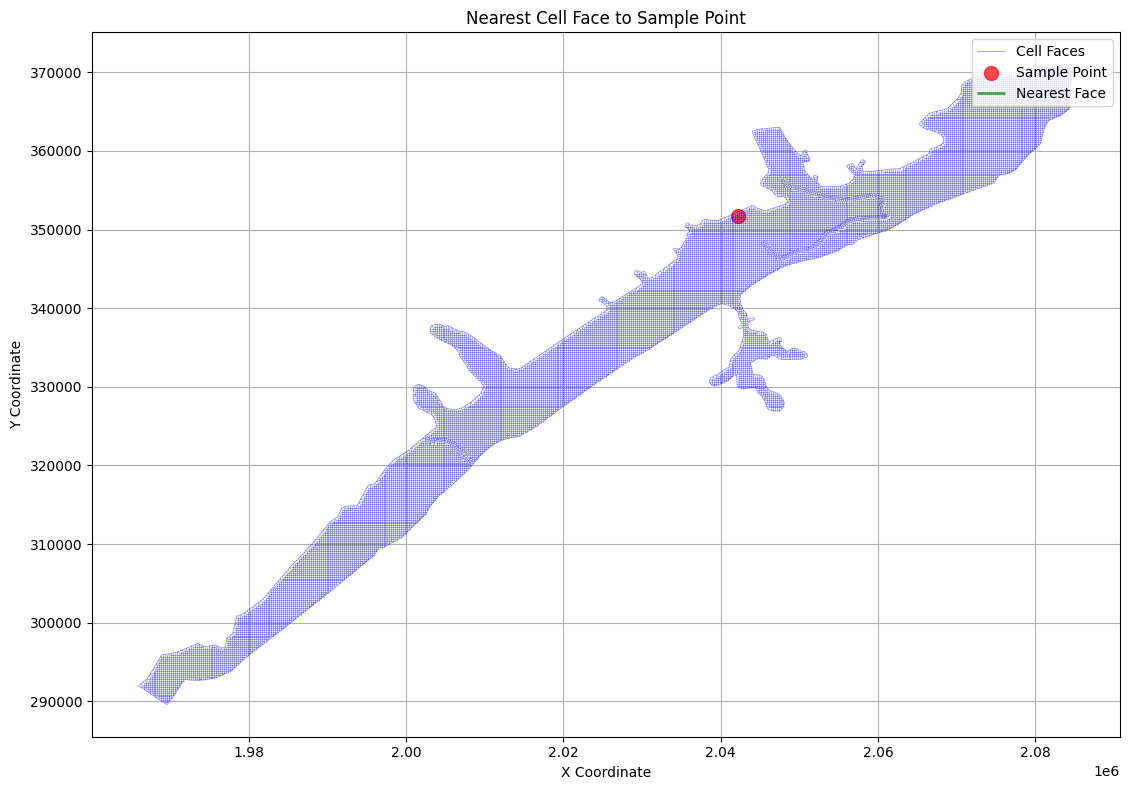

In [16]:
# Function to find the nearest cell face to a given point
def find_nearest_cell_face(point, cell_faces_df):
    """
    Find the nearest cell face to a given point.

    Args:
        point (shapely.geometry.Point): The input point.
        cell_faces_df (GeoDataFrame): DataFrame containing cell face linestrings.

    Returns:
        int: The face_id of the nearest cell face.
        float: The distance to the nearest cell face.
    """
    # Calculate distances from the input point to all cell faces
    distances = cell_faces_df.geometry.distance(point)

    # Find the index of the minimum distance
    nearest_index = distances.idxmin()

    # Get the face_id and distance of the nearest cell face
    nearest_face_id = cell_faces_df.loc[nearest_index, 'face_id']
    nearest_distance = distances[nearest_index]

    return nearest_face_id, nearest_distance

# Example usage
print("\nExample: Finding the nearest cell face to a given point")

# Create a sample point (you can replace this with any point of interest)
from shapely.geometry import Point
from geopandas import GeoDataFrame

# Get the projection from the geometry file
# projection = HdfUtils.get_projection(hdf_path=geom_hdf_path) # This was done in a previous code cell
if projection:
    print(f"Using projection: {projection}")
else:
    print("No projection information found. Using default CRS.")
    projection = "EPSG:4326"  # Default to WGS84 if no projection is found

# Create the sample point with the correct CRS
sample_point = GeoDataFrame({'geometry': [Point(2042250, 351750)]}, crs=projection)

if not mesh_cell_faces.empty and not sample_point.empty:
    # Ensure the CRS of the sample point matches the mesh_cell_faces
    if sample_point.crs != mesh_cell_faces.crs:
        sample_point = sample_point.to_crs(mesh_cell_faces.crs)
    
    nearest_face_id, distance = find_nearest_cell_face(sample_point.geometry.iloc[0], mesh_cell_faces)
    print(f"Nearest cell face to point {sample_point.geometry.iloc[0].coords[0]}:")
    print(f"Face ID: {nearest_face_id}")
    print(f"Distance: {distance:.2f} units")

    # Visualize the result
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot all cell faces
    mesh_cell_faces.plot(ax=ax, color='blue', linewidth=0.5, alpha=0.5, label='Cell Faces')
    
    # Plot the sample point
    sample_point.plot(ax=ax, color='red', markersize=100, alpha=0.7, label='Sample Point')
    
    # Plot the nearest cell face
    nearest_face = mesh_cell_faces[mesh_cell_faces['face_id'] == nearest_face_id]
    nearest_face.plot(ax=ax, color='green', linewidth=2, alpha=0.7, label='Nearest Face')
    
    # Set labels and title
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('Nearest Cell Face to Sample Point')
    
    # Add legend and grid
    ax.legend()
    ax.grid(True)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
else:
    print("Unable to perform nearest cell face search due to missing data.")



In [17]:
# Example: Extract Cell Polygons
print("\nExample 6: Extracting Cell Polygons")
cell_polygons_df = HdfMesh.get_mesh_cell_polygons(geom_hdf_path)

2025-03-15 08:42:38 - ras_commander.HdfMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:38 - ras_commander.HdfMesh - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:38 - ras_commander.HdfMesh - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:38 - ras_commander.HdfMesh - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf



Example 6: Extracting Cell Polygons


2025-03-15 08:42:38 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:38 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:40 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:40 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf


cell_polygons_df:

| mesh_name    | cell_id | geometry                                      |
|--------------|---------|-----------------------------------------------|
| BaldEagleCr  | 0       | POLYGON ((2082875 370625, 2082723.922 370776.0... |
| BaldEagleCr  | 1       | POLYGON ((2083125 370625, 2083125 370844.185, ... |
| BaldEagleCr  | 2       | POLYGON ((2083375 370625, 2083375 370886.638, ... |
| BaldEagleCr  | 3       | POLYGON ((2083625 370625, 2083625 370925.693, ... |
| BaldEagleCr  | 4       | POLYGON ((2083875 370625, 2083875 370958.588, ... |

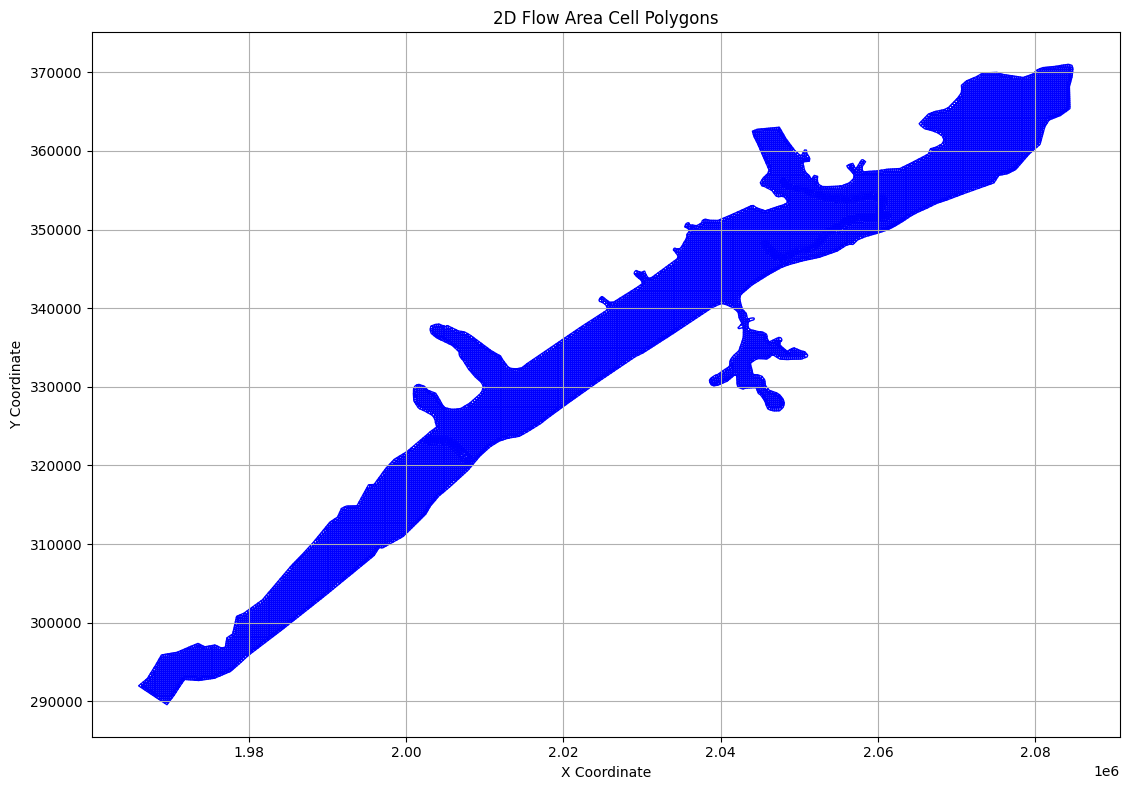

In [18]:
# Plot Cell Polygons
if not cell_polygons_df.empty:
    cell_polygons_df.head()
else:
    print("No Cell Polygons found.")

# Plot cell polygons
if not cell_polygons_df.empty:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot cell polygons
    cell_polygons_df.plot(ax=ax, edgecolor='blue', facecolor='none')
    
    # Set labels and title
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('2D Flow Area Cell Polygons')
    
    # Add grid
    ax.grid(True)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
else:
    print("No cell polygon data available for plotting.")

In [19]:
# Extract Cell Info
print("\nExample 5: Extracting Cell Info")
cell_info_df = HdfMesh.get_mesh_cell_points(geom_hdf_path)

2025-03-15 08:42:43 - ras_commander.HdfMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:43 - ras_commander.HdfMesh - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:43 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf



Example 5: Extracting Cell Info


2025-03-15 08:42:43 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf


cell_info_df: 

| mesh_name    | cell_id | geometry                          |
|--------------|---------|-----------------------------------|
| BaldEagleCr  | 0       | POINT (2083000 370750)           |
| BaldEagleCr  | 1       | POINT (2083250 370750)           |
| BaldEagleCr  | 2       | POINT (2083500 370750)           |
| BaldEagleCr  | 3       | POINT (2083750 370750)           |
| BaldEagleCr  | 4       | POINT (2084000 370750)           |

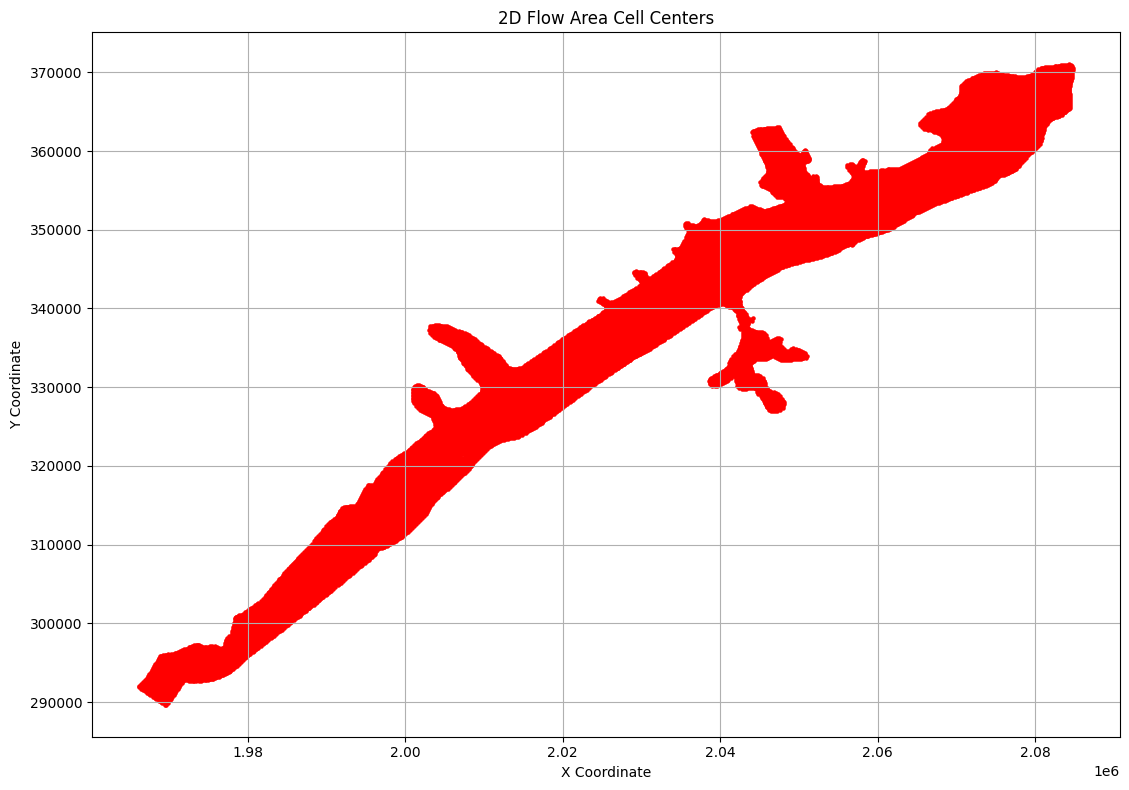

In [20]:
# Plot Cell Info
if not cell_info_df.empty:
    cell_info_df.head()
else:
    print("No Cell Info found.")

# Plot cell centers
import matplotlib.pyplot as plt

if not cell_info_df.empty:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot cell centers
    cell_info_df.plot(ax=ax, color='red', markersize=5)
    
    # Set labels and title
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('2D Flow Area Cell Centers')
    
    # Add grid
    ax.grid(True)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
else:
    print("No cell data available for plotting.")



Example: Finding the nearest cell to a given point
Using projection: PROJCS["NAD_1983_StatePlane_Pennsylvania_North_FIPS_3701_Feet",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic"],PARAMETER["False_Easting",1968500.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-77.75],PARAMETER["Standard_Parallel_1",40.88333333333333],PARAMETER["Standard_Parallel_2",41.95],PARAMETER["Latitude_Of_Origin",40.16666666666666],UNIT["Foot_US",0.3048006096012192]]
Nearest cell to point (2083500.0, 370800.0):
Cell ID: 2
Distance: 50.00 units


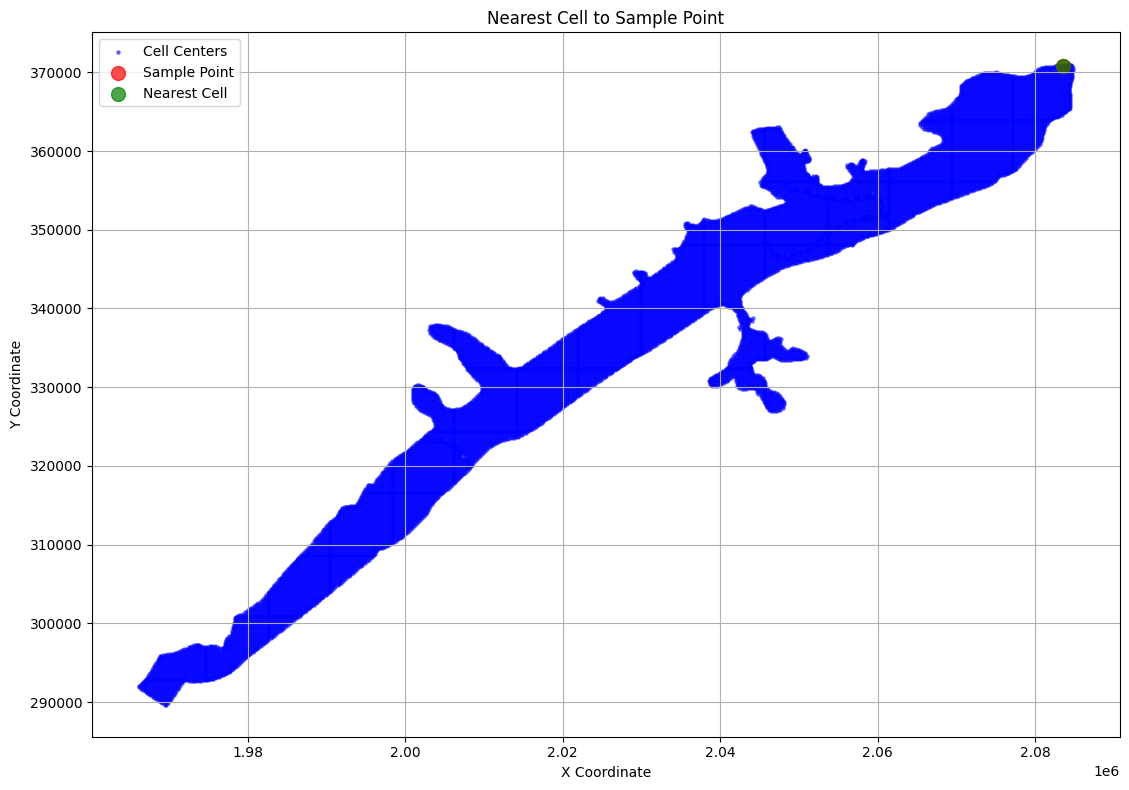

In [21]:
# Function to find the nearest cell center to a given point
def find_nearest_cell(point, cell_centers_df):
    """
    Find the nearest cell center to a given point.

    Args:
        point (shapely.geometry.Point): The input point.
        cell_centers_df (GeoDataFrame): DataFrame containing cell center points.

    Returns:
        int: The cell_id of the nearest cell.
        float: The distance to the nearest cell center.
    """
    # Calculate distances from the input point to all cell centers
    distances = cell_centers_df.geometry.distance(point)

    # Find the index of the minimum distance
    nearest_index = distances.idxmin()

    # Get the cell_id and distance of the nearest cell
    nearest_cell_id = cell_centers_df.loc[nearest_index, 'cell_id']
    nearest_distance = distances[nearest_index]

    return nearest_cell_id, nearest_distance

# Example usage
print("\nExample: Finding the nearest cell to a given point")

# Create a sample point (you can replace this with any point of interest)
from shapely.geometry import Point
from geopandas import GeoDataFrame

# Get the projection from the geometry file
# projection = HdfUtils.get_projection(hdf_path=geom_hdf_path) # This was done in a previous code cell
if projection:
    print(f"Using projection: {projection}")
else:
    print("No projection information found. Using default CRS.")
    projection = "EPSG:4326"  # Default to WGS84 if no projection is found

# Create the sample point with the correct CRS
sample_point = GeoDataFrame({'geometry': [Point(2083500, 370800)]}, crs=projection)

if not cell_info_df.empty and not sample_point.empty:
    # Ensure the CRS of the sample point matches the cell_info_df
    if sample_point.crs != cell_info_df.crs:
        sample_point = sample_point.to_crs(cell_info_df.crs)
    
    nearest_cell_id, distance = find_nearest_cell(sample_point.geometry.iloc[0], cell_info_df)
    print(f"Nearest cell to point {sample_point.geometry.iloc[0].coords[0]}:")
    print(f"Cell ID: {nearest_cell_id}")
    print(f"Distance: {distance:.2f} units")

    # Visualize the result
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot all cell centers
    cell_info_df.plot(ax=ax, color='blue', markersize=5, alpha=0.5, label='Cell Centers')
    
    # Plot the sample point
    sample_point.plot(ax=ax, color='red', markersize=100, alpha=0.7, label='Sample Point')
    
    # Plot the nearest cell center
    nearest_cell = cell_info_df[cell_info_df['cell_id'] == nearest_cell_id]
    nearest_cell.plot(ax=ax, color='green', markersize=100, alpha=0.7, label='Nearest Cell')
    
    # Set labels and title
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('Nearest Cell to Sample Point')
    
    # Add legend and grid
    ax.legend()
    ax.grid(True)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
else:
    print("Unable to perform nearest cell search due to missing data.")


In [22]:
# Get geometry structures attributes
print("\nGetting geometry structures attributes")
geom_structures_attrs = HdfStruc.get_geom_structures_attrs(geom_hdf_path)
if geom_structures_attrs:
    print("Geometry structures attributes:")
    for key, value in geom_structures_attrs.items():
        print(f"{key}: {value}")
else:
    print("No geometry structures attributes found.")

2025-03-15 08:42:45 - ras_commander.HdfStruc - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf



Getting geometry structures attributes
Geometry structures attributes:
Bridge/Culvert Count: 0
Connection Count: 1
Has Bridge Opening (2D): 0
Inline Structure Count: 0
Lateral Structure Count: 0


In [23]:
# TODO: Paths and Functions for each type of structure: 

# Getting geometry structures attributes
# Geometry structures attributes:
# Bridge/Culvert Count: 0
# Connection Count: 4
# Has Bridge Opening (2D): 0
# Inline Structure Count: 0
# Lateral Structure Count: 0

In [24]:
# Example: Extract Boundary Condition Lines and Plot with 2D Flow Area Perimeter Polygons
print("\nExample 7: Extracting Boundary Condition Lines and Plotting with 2D Flow Area Perimeter Polygons")
bc_lines_df = HdfBndry.get_bc_lines(geom_hdf_path)

if not bc_lines_df.empty:
    bc_lines_df.head()
else:
    print("No Boundary Condition Lines found.")

2025-03-15 08:42:45 - ras_commander.HdfBndry - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:45 - ras_commander.HdfBase - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:45 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:45 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf



Example 7: Extracting Boundary Condition Lines and Plotting with 2D Flow Area Perimeter Polygons


| bc_line_id |         name         |    mesh_name    |    type    |                                           geometry                                            |
|-------------|----------------------|------------------|------------|------------------------------------------------------------------------------------------------|
|      0      |     DSNormalDepth    |   BaldEagleCr    |  External  | LINESTRING (2082004.235 364024.82, 2083193.546...)                                          |
|      1      |       DS2NormalD     |   BaldEagleCr    |  External  | LINESTRING (2084425.804 365392.892, 2084354.64...)                                          |
|      2      |   Upstream Inflow    |   BaldEagleCr    |  External  | LINESTRING (1967473.737 290973.629, 1969582.89...)                                          |

C:\Users\billk\AppData\Local\Temp\ipykernel_19692\1355808240.py:27: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


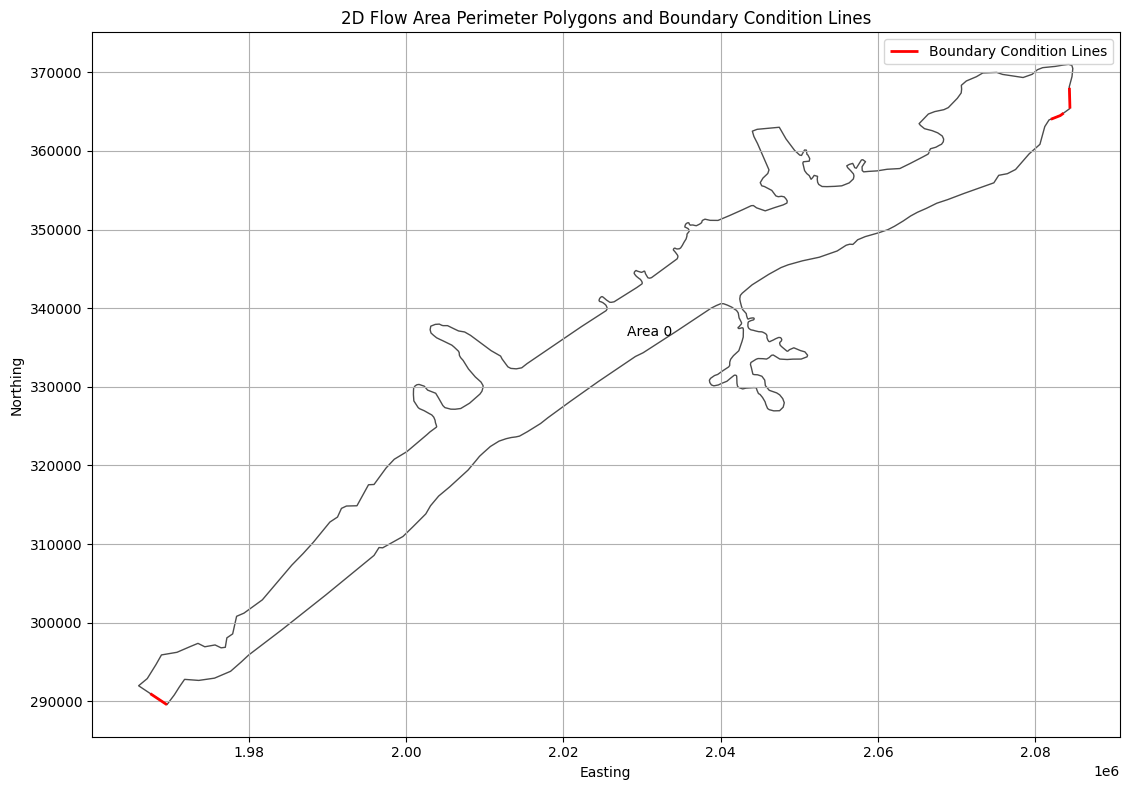

In [25]:
# Plot Boundary Condition Lines with Perimeter
# Plot if data exists
if not bc_lines_df.empty or not mesh_areas.empty:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot 2D Flow Area Perimeter Polygons
    if not mesh_areas.empty:
        mesh_areas.plot(ax=ax, edgecolor='black', facecolor='none', alpha=0.7, label='2D Flow Area')
        
        # Add labels for each polygon
        for idx, row in mesh_areas.iterrows():
            centroid = row.geometry.centroid
            label = row.get('Name', f'Area {idx}')
            ax.annotate(label, (centroid.x, centroid.y), ha='center', va='center')
    
    # Plot boundary condition lines
    if not bc_lines_df.empty:
        bc_lines_df.plot(ax=ax, color='red', linewidth=2, label='Boundary Condition Lines')
    
    # Set labels and title
    ax.set_xlabel('Easting')
    ax.set_ylabel('Northing')
    ax.set_title('2D Flow Area Perimeter Polygons and Boundary Condition Lines')
    
    # Add grid and legend
    ax.grid(True)
    ax.legend()
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
else:
    print("No data available for plotting.")

In [26]:
# Example: Extract Breaklines and Plot with 2D Flow Area Perimeter Polygons
print("\nExample 8: Extracting Breaklines and Plotting with 2D Flow Area Perimeter Polygons")
breaklines_gdf = HdfBndry.get_breaklines(geom_hdf_path)
if not breaklines_gdf.empty:
    breaklines_gdf
else:
    print("No Breaklines found.")

2025-03-15 08:42:46 - ras_commander.HdfBndry - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:46 - ras_commander.HdfBase - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:46 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:46 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf



Example 8: Extracting Breaklines and Plotting with 2D Flow Area Perimeter Polygons


breaklines_gdf:


| bl_id | Name      | geometry |
|-------|-----------|----------|
| 0     | SayersDam | LINESTRING (2002361.246 323707.927, 2002741.35...) |
| 1     | Lower     | LINESTRING (2060356.422 351786.819, 2060316.47...) |
| 2     | Middle    | LINESTRING (2052757.788 348470.547, 2052785.84...) |
| 3     | Upper     | LINESTRING (2045597.199 348412.994, 2045638.91...) |

C:\Users\billk\AppData\Local\Temp\ipykernel_19692\3836499436.py:26: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


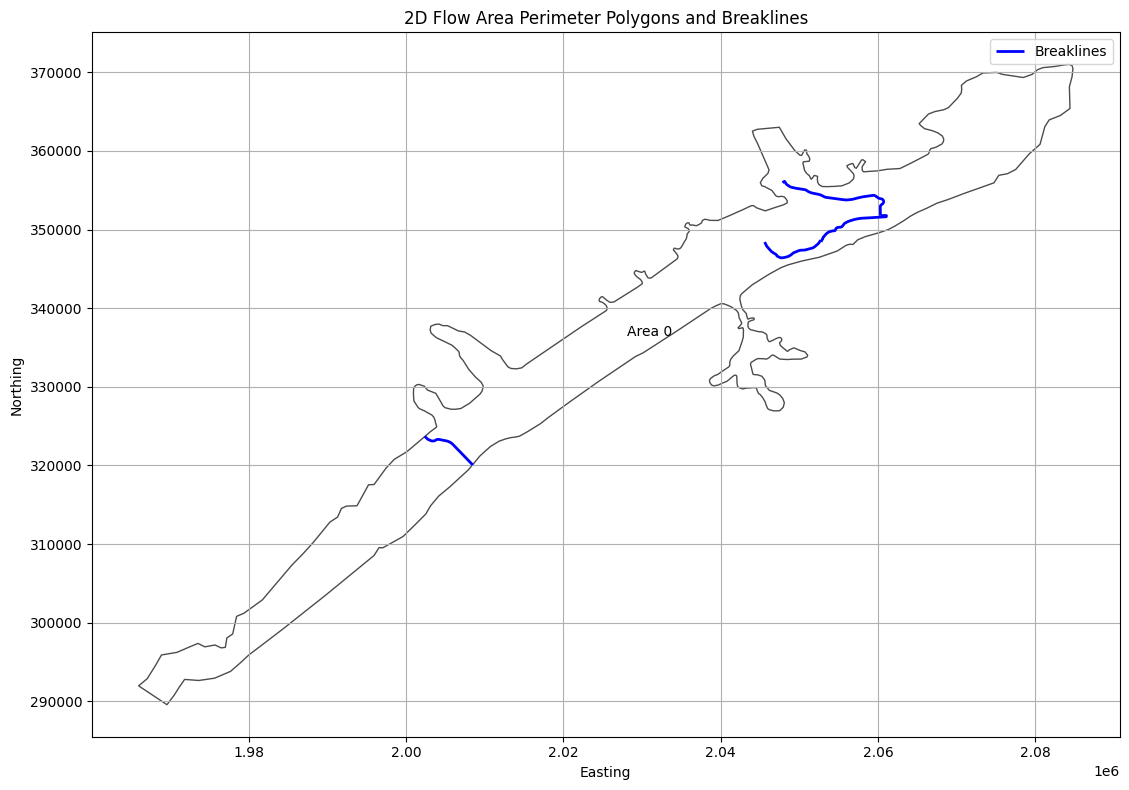

In [27]:
# Plot breaklines and 2D Flow Area Perimeter Polygons if they exist
if not breaklines_gdf.empty or not mesh_areas.empty:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot 2D Flow Area Perimeter Polygons
    if not mesh_areas.empty:
        mesh_areas.plot(ax=ax, edgecolor='black', facecolor='none', alpha=0.7, label='2D Flow Area')
        
        # Add labels for each polygon
        for idx, row in mesh_areas.iterrows():
            centroid = row.geometry.centroid
            label = row.get('Name', f'Area {idx}')
            ax.annotate(label, (centroid.x, centroid.y), ha='center', va='center')
    
    # Plot breaklines
    if not breaklines_gdf.empty:
        breaklines_gdf.plot(ax=ax, color='blue', linewidth=2, label='Breaklines')
    
    # Set labels and title
    ax.set_xlabel('Easting')
    ax.set_ylabel('Northing')
    ax.set_title('2D Flow Area Perimeter Polygons and Breaklines')
    
    # Add grid and legend
    ax.grid(True)
    ax.legend()
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
else:
    print("No data available for plotting.")

In [28]:
# Example: Get structures
structures_gdf = HdfStruc.get_structures(geom_hdf_path)
print("Structures:")
if not structures_gdf.empty:
    structures_gdf.head()
else:
    print("No structures found in the geometry file.")

2025-03-15 08:42:46 - ras_commander.HdfStruc - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:46 - ras_commander.HdfBase - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:46 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:46 - ras_commander.HdfStruc - INFO - Successfully extracted structures GeoDataFrame.
2025-03-15 08:42:46 - ras_commander.HdfStruc - INFO - Successfully extracted structures GeoDataFrame with attributes.


Structures:


structures_gdf: 

| Type | Mode | River | Reach | RS | Connection | Groupname | US Type | US River | US Reach | ... | US XS Mann (Count) | US BR Mann (Index) | US BR Mann (Count) | DS XS Mann (Index) | DS XS Mann (Count) | DS BR Mann (Index) | DS BR Mann (Count) | RC (Index) | RC (Count) | Profile_Data |
|------|------|-------|-------|-------|------------|-----------|----------|-----------|-----------|-----|-------------------|-------------------|-------------------|-------------------|-------------------|-------------------|-------------------|------------|------------|--------------|
| Connection | Weir/Gate/Culverts | | | | Sayers Dam | BaldEagleCr, Sayers Dam | 2D | | | ... | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | [{'Station': 0.0, 'Elevation': 683.0}, {'Stati... |

In [29]:
# Example: Get boundary condition lines
bc_lines_gdf = HdfBndry.get_bc_lines(geom_hdf_path)
print("\nBoundary Condition Lines:")

bc_lines_gdf


2025-03-15 08:42:46 - ras_commander.HdfBndry - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:46 - ras_commander.HdfBase - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:46 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:46 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf



Boundary Condition Lines:


,Name,SA-2D,Type,Length,geometry,bc_line_id
0,DSNormalDepth,BaldEagleCr,External,1801.303345,"LINESTRING (2082004.235 364024.82, 2083193.546...",0
1,DS2NormalD,BaldEagleCr,External,2633.932617,"LINESTRING (2084425.804 365392.892, 2084354.64...",1
2,Upstream Inflow,BaldEagleCr,External,2533.638672,"LINESTRING (1967473.737 290973.629, 1969582.89...",2


In [30]:
# Example: Get reference points
ref_points_gdf = HdfBndry.get_reference_points(geom_hdf_path)
print("\nReference Points:")
ref_points_gdf

# There are no reference points in this example project (for demonstration only)

2025-03-15 08:42:46 - ras_commander.HdfBndry - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf



Reference Points:


""


In [31]:
# Example: Extract Refinement Regions
print("\nExample: Extracting Refinement Regions")

# Make sure to pass the bald_eagle object as the ras_object parameter
refinement_regions_df = HdfBndry.get_refinement_regions(geom_hdf_path)

if not refinement_regions_df.empty:
    print("Refinement Regions DataFrame:")
    display(refinement_regions_df.head())
    
    # Plot refinement regions
    fig, ax = plt.subplots(figsize=(12, 8))
    refinement_regions_df.plot(ax=ax, column='CellSize', legend=True, 
                               legend_kwds={'label': 'Cell Size', 'orientation': 'horizontal'},
                               cmap='viridis')
    ax.set_title('2D Mesh Area Refinement Regions')
    ax.set_xlabel('Easting')
    ax.set_ylabel('Northing')
    plt.tight_layout()
    plt.show()
else:
    print("No refinement regions found in the geometry file.")

# Example: Analyze Refinement Regions
if not refinement_regions_df.empty:
    print("\nRefinement Regions Analysis:")
    print(f"Total number of refinement regions: {len(refinement_regions_df)}")
    print("\nCell Size Statistics:")
    print(refinement_regions_df['CellSize'].describe())
    
    # Group by Shape Type
    shape_type_counts = refinement_regions_df['ShapeType'].value_counts()
    print("\nRefinement Region Shape Types:")
    print(shape_type_counts)
    
    # Plot Shape Type distribution
    plt.figure(figsize=(10, 6))
    shape_type_counts.plot(kind='bar')
    plt.title('Distribution of Refinement Region Shape Types')
    plt.xlabel('Shape Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

2025-03-15 08:42:46 - ras_commander.HdfBndry - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf



Example: Extracting Refinement Regions
No refinement regions found in the geometry file.


In [32]:
# Extract Compute Messages as String
print("Extracting Compute Messages")

import h5py
import numpy as np



def extract_string_from_hdf(results_hdf_filename: str, hdf_path: str) -> str:
    """
    Extract string from HDF object at a given path

    Parameters
    ----------
    results_hdf_filename : str
        Name of the HDF file
    hdf_path : str
        Path of the object in the HDF file

    Returns
    -------
    str
        Extracted string from the specified HDF object
    """
    with h5py.File(results_hdf_filename, 'r') as hdf_file:
        try:
            hdf_object = hdf_file[hdf_path]
            if isinstance(hdf_object, h5py.Group):
                return f"Group: {hdf_path}\nContents: {list(hdf_object.keys())}"
            elif isinstance(hdf_object, h5py.Dataset):
                data = hdf_object[()]
                if isinstance(data, bytes):
                    return data.decode('utf-8')
                elif isinstance(data, np.ndarray) and data.dtype.kind == 'S':
                    return [v.decode('utf-8') for v in data]
                else:
                    return str(data)
            else:
                return f"Unsupported object type: {type(hdf_object)}"
        except KeyError:
            return f"Path not found: {hdf_path}"



try:
    results_summary_string = extract_string_from_hdf(plan_hdf_path, '/Results/Summary/Compute Messages (text)')
    print("Compute Messages:")
    
    # Parse and print the compute messages in a more visually friendly way
    messages = results_summary_string[0].split('\r\n')
    
    for message in messages:
        if message.strip():  # Skip empty lines
            if ':' in message:
                key, value = message.split(':', 1)
                print(f"{key.strip():40} : {value.strip()}")
            else:
                print(f"\n{message.strip()}")
    
    # Print computation summary in a table format
    print("\nComputation Summary:")
    print("-" * 50)
    print(f"{'Computation Task':<30} {'Time':<20}")
    print("-" * 50)
    for line in messages:
        if 'Computation Task' in line:
            task, time = line.split('\t')
            print(f"{task:<30} {time:<20}")
    
    print("\nComputation Speed:")
    print("-" * 50)
    print(f"{'Task':<30} {'Simulation/Runtime':<20}")
    print("-" * 50)
    for line in messages:
        if 'Computation Speed' in line:
            task, speed = line.split('\t')
            print(f"{task:<30} {speed:<20}")

except Exception as e:
    print(f"Error extracting compute messages: {str(e)}")
    print("\nNote: If 'Results/Summary Output' is not in the file structure, it might indicate that the simulation didn't complete successfully or the results weren't saved properly.")

 



Extracting Compute Messages
Compute Messages:
Plan                                     : 'Gridded Precip - Infiltration' (BaldEagleDamBrk.p06)
Simulation started at                    : 15Mar2025 08:34:11 AM

Writing Plan GIS Data...

Completed Writing Plan GIS Data

Writing Geometry...
Computing 2D Flow Area 'BaldEagleCr' tables : Property tables do not exist.

2D Flow Area 'BaldEagleCr' tables complete 33.26 sec

Completed Writing Geometry

Writing Event Conditions ...

Processing Precipitation data...

(assumes geometry data is geo-referenced)

Finished Processing Precipitation data (4.998s)

Completed Writing Event Condition Data

Geometric Preprocessor HEC-RAS 6.6 September 2024

Finished Processing Geometry

Performing Unsteady Flow Simulation  HEC-RAS 6.6 September 2024
Unsteady Input Summary                   : 

2D Unsteady Diffusion Wave Equation Set (fastest)
2D number of Solver Cores                : 4

Maximum adaptive timestep = 40.0    Minimum adaptive timestep = 20.0

I

# Note: Plan 06 does not have any errors, so this dataframe will be empty (for demonstration purposes only)

In [33]:
# Advanced Compute Messages Example 
import pandas as pd
import re
import matplotlib.pyplot as plt
import geopandas as gpd
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

def parse_2d_compute_messages(compute_messages):
    """
    Parse 2D compute messages to extract data lines, clean the data, 
    and retrieve top 20 cells with the highest error.

    Parameters:
        compute_messages (list or str): The raw compute messages.

    Returns:
        tuple: A tuple containing the parsed compute messages string and the main DataFrame.
    """
    try:
        # Handle both list and string inputs
        if isinstance(compute_messages, list):
            compute_messages = '\n'.join(compute_messages)
        elif not isinstance(compute_messages, str):
            logging.error(f"Unexpected type for compute_messages: {type(compute_messages)}")
            return "", pd.DataFrame()

        # Split the message into lines
        lines = compute_messages.split('\n')
        logging.info("Successfully split compute messages into lines.")
        
        # Initialize lists to store parsed data
        data_lines = []
        print("Data lines:", data_lines)
        header_lines = []
        print("Header lines:", header_lines) 
        footer_lines = []
        print("Footer lines:", footer_lines)

        
        # More flexible timestamp pattern that includes various message types
        timestamp_pattern = re.compile(r'^\d{2}[A-Z]{3}\d{4}\s+\d{2}:\d{2}:\d{2}')
        logging.debug("Compiled timestamp regular expression.")
        
        data_started = False
        for line in lines:
            stripped_line = line.strip()
            if timestamp_pattern.match(stripped_line):
                data_started = True
                # Split the line and add to data_lines
                parts = stripped_line.split()
                if len(parts) >= 8:  # Ensure we have all expected columns
                    # Combine Date and Time into 'Date and Time'
                    date_time = f"{parts[0]} {parts[1]}"
                    location = parts[2]
                    cell_type = f"{parts[3]} {parts[4]}"
                    cell_number = parts[5]
                    wsel = parts[6]
                    error = parts[7]
                    iterations = parts[8] if len(parts) > 8 else None
                    data_lines.append([date_time, location, cell_type, cell_number, wsel, error, iterations])
                    logging.debug(f"Parsed data line: {data_lines[-1]}")
                else:
                    logging.warning(f"Line skipped due to insufficient parts: {stripped_line}")
            elif not data_started:
                header_lines.append(stripped_line)
            elif data_started and not stripped_line:
                data_started = False
            elif not data_started:
                footer_lines.append(stripped_line)
        
        # Create DataFrame from data lines
        df = pd.DataFrame(
            data_lines, 
            columns=['Date and Time', 'Location', 'Cell Type', 'Cell Number', 'WSEL', 'ERROR', 'ITERATIONS']
        )
        logging.info("Created DataFrame from parsed data lines.")
        
        # Clean and convert columns to appropriate types
        df['Cell Number'] = (
            pd.to_numeric(df['Cell Number'].replace('#', pd.NA), errors='coerce')
            .fillna(-1)
            .astype('Int64')
        )
        df['WSEL'] = pd.to_numeric(df['WSEL'], errors='coerce')
        df['ERROR'] = pd.to_numeric(df['ERROR'], errors='coerce')
        df['ITERATIONS'] = pd.to_numeric(df['ITERATIONS'], errors='coerce').astype('Int64')
        logging.info("Converted DataFrame columns to appropriate types.")
        
        # Get top 20 cells with highest error
        top_20_cells = (
            df.sort_values('ERROR', ascending=False)
            .drop_duplicates('Cell Number')
            .head(20)
        )
        
        # Construct the reordered message
        reordered_message = '\n'.join(header_lines + 
                                      ['\nTop 20 Cells with Highest Error:'] + 
                                      [' '.join(map(str, row)) for row in top_20_cells.values] + 
                                      ['\n'] + footer_lines)
        
        logging.info("Reordered compute messages.")
        
        return reordered_message, df
    except Exception as e:
        logging.error(f"Error parsing compute messages: {e}")
        return "", pd.DataFrame()

# Use the function to parse compute messages
parsed_messages, df = parse_2d_compute_messages(results_summary_string)

print(parsed_messages)
print(df)

# Get top 20 cells with highest error
if not df.empty and 'ERROR' in df.columns:
    top_20_cells = (
        df.sort_values('ERROR', ascending=False)
        .drop_duplicates('Cell Number')
        .head(20)
    )
else:
    logging.warning("Unable to get top 20 cells with highest error. DataFrame is empty or 'ERROR' column is missing.")
    top_20_cells = pd.DataFrame()

# Example: Get 2D Flow Area Perimeter Polygons (mesh_areas)
print("\nExample: Extracting 2D Flow Area Perimeter Polygons")
mesh_areas = HdfMesh.get_mesh_areas(geom_hdf_path)

print("\n2D Flow Area Groups and Perimeters:")
if not mesh_areas.empty:
    print("Available columns:", mesh_areas.columns.tolist())
    
    # Display the first few rows of the mesh_areas DataFrame
    print("\nFirst few rows of mesh_areas DataFrame:")
    mesh_areas.head()
else:
    print("No 2D Flow Area groups found in the HDF file.")

# Use the previously extracted cell_polygons_df
print("\nTop 20 Cell Polygons:")
if 'cell_polygons_df' in locals() and not cell_polygons_df.empty and not top_20_cells.empty:
    # Get the cell numbers from top_20_cells
    top_20_cell_numbers = top_20_cells['Cell Number'].tolist()
    
    # Filter cell_polygons_df to only include top 20 cells
    top_20_cell_polygons = cell_polygons_df[cell_polygons_df['cell_id'].isin(top_20_cell_numbers)]
    
    display(top_20_cell_polygons)

    # Plot top 20 cell polygons and mesh areas
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot mesh areas
    mesh_areas.plot(ax=ax, edgecolor='red', facecolor='none', alpha=0.5, label='Mesh Areas')
    
    # Plot top 20 cell polygons
    top_20_cell_polygons.plot(ax=ax, edgecolor='blue', facecolor='none', alpha=0.7, label='Top 20 Error Cells')
    
    # Set labels and title
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('2D Flow Area Perimeters and Top 20 Cell Polygons')
    
    # Add legend
    ax.legend()
    
    # Add grid
    ax.grid(True)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
else:
    print("No Cell Polygons found or no top 20 cells with highest error available.")
    print("Unable to plot cell polygons.")

2025-03-15 08:42:47 - root - INFO - Successfully split compute messages into lines.
2025-03-15 08:42:47 - root - WARNING - Line skipped due to insufficient parts: 09SEP2018 00:01:20       timestep =            40             (sec)
2025-03-15 08:42:47 - root - WARNING - Line skipped due to insufficient parts: 12SEP2018 21:12:00       timestep =            20             (sec)
2025-03-15 08:42:47 - root - INFO - Created DataFrame from parsed data lines.
2025-03-15 08:42:47 - root - INFO - Converted DataFrame columns to appropriate types.
2025-03-15 08:42:47 - root - INFO - Reordered compute messages.
2025-03-15 08:42:47 - root - WARNING - Unable to get top 20 cells with highest error. DataFrame is empty or 'ERROR' column is missing.
2025-03-15 08:42:47 - ras_commander.HdfMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:42:47 - ras_commander.HdfMesh - INFO - Using existing HDF file: c:\GH\ras-commander\ex

Data lines: []
Header lines: []
Footer lines: []
Plan: 'Gridded Precip - Infiltration' (BaldEagleDamBrk.p06)
Simulation started at: 15Mar2025 08:34:11 AM

Writing Plan GIS Data...
Completed Writing Plan GIS Data
Writing Geometry...
Computing 2D Flow Area 'BaldEagleCr' tables: Property tables do not exist.
2D Flow Area 'BaldEagleCr' tables complete 33.26 sec
Completed Writing Geometry
Writing Event Conditions ...

Processing Precipitation data...
(assumes geometry data is geo-referenced)
Finished Processing Precipitation data (4.998s)
Completed Writing Event Condition Data


Geometric Preprocessor HEC-RAS 6.6 September 2024


Finished Processing Geometry


Performing Unsteady Flow Simulation  HEC-RAS 6.6 September 2024


Unsteady Input Summary:
2D Unsteady Diffusion Wave Equation Set (fastest)
2D number of Solver Cores:    4

Maximum adaptive timestep = 40.0    Minimum adaptive timestep = 20.0
Initial adaptive timestep = 20.0

Overall Volume Accounting Error in Acre Feet:            0.4

In [34]:
# Exploratory Example for Debugging or New Features: List all paths, groups, and attributes under "/Results/Unsteady/Summary/Volume Accounting"
HdfBase.get_dataset_info(plan_hdf_path, "/Results/Unsteady/Summary/Volume Accounting")

2025-03-15 08:42:47 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf



Exploring group: /Results/Unsteady/Summary/Volume Accounting


    Group: /Results/Unsteady/Summary/Volume Accounting/Volume Accounting 1D
    Attributes for /Results/Unsteady/Summary/Volume Accounting/Volume Accounting 1D:
        Diversions: -0.0
        Flow DS Out: 0.0
        Flow US In: 0.0
        Groundwater: -0.0
        Hydro Lat: 0.0
        Hydro SA: 0.0
        Precip Excess (acre feet): 0.0
        Precip Excess (inches): 0.0
        Reach Final 1D: 0.0
        Reach Start 1D: 0.0
        SA Final: 0.0
        SA Starting: 0.0
        Vol Accounting in: b'Acre Feet'

    Group: /Results/Unsteady/Summary/Volume Accounting/Volume Accounting 2D
    Attributes for /Results/Unsteady/Summary/Volume Accounting/Volume Accounting 2D:
        Vol Accounting in: b'Acre Feet'
        Group: /Results/Unsteady/Summary/Volume Accounting/Volume Accounting 2D/BaldEagleCr
    Attributes for /Results/Unsteady/Summary/Volume Accounting/Volume Accounting 2D/BaldEagleCr:
        Cum Inflow: 1

In [35]:
# Example 12: Extract Plan Parameters and Volume Accounting
print("\nExample 12: Extracting Plan Parameters and Volume Accounting Data")

# Extract plan parameters
plan_parameters_df = HdfPlan.get_plan_parameters(plan_hdf_path)

# Extract volume accounting data
volume_accounting_df = HdfResultsPlan.get_volume_accounting(plan_hdf_path)

print("\nPlan Parameters DataFrame:")
plan_parameters_df

print("\nVolume Accounting DataFrame:")
volume_accounting_df

2025-03-15 08:42:47 - ras_commander.HdfPlan - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:47 - ras_commander.HdfResultsPlan - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf



Example 12: Extracting Plan Parameters and Volume Accounting Data

Plan Parameters DataFrame:

Volume Accounting DataFrame:


,Error,Error Percent,Precipitation Excess (acre feet),Precipitation Excess (inches),Total Boundary Flux of Water In,Total Boundary Flux of Water Out,Vol Accounting in,Volume Ending,Volume Starting
0,0.470055,0.000332,3756.872803,1.707615,141685.0,17240.263672,b'Acre Feet',124445.203125,0.0


------

# RasPlanHdf Class Functions

-----

In [36]:
# Example: Get plan start time
start_time = HdfPlan.get_plan_start_time(plan_hdf_path)
print(f"Simulation start time: {start_time}")

2025-03-15 08:42:47 - ras_commander.HdfPlan - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf


Simulation start time: 2018-09-09 00:00:00


Simulation start time: 2018-09-09 00:00:00

In [37]:
# Example: Get plan end time
end_time = HdfPlan.get_plan_end_time(plan_hdf_path)
print(f"Simulation end time: {end_time}")

2025-03-15 08:42:47 - ras_commander.HdfPlan - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf


Simulation end time: 2018-09-14 00:00:00


Simulation end time: 2018-09-14 00:00:00

In [38]:
# Example: Get maximum iteration count for mesh cells
max_iter_df = HdfResultsMesh.get_mesh_max_iter(plan_hdf_path)
print("\nMesh Max Iterations:")
print(max_iter_df.attrs)
max_iter_df.head()

2025-03-15 08:42:47 - ras_commander.HdfResultsMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:47 - ras_commander.HdfResultsMesh - INFO - Processing summary output for variable: Cell Last Iteration
2025-03-15 08:42:47 - ras_commander.HdfMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:47 - ras_commander.HdfMesh - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:47 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:47 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:47 - ras_commander.HdfBase - INFO - Us


Mesh Max Iterations:
{'mesh_name': 'BaldEagleCr', 'Cell': 'Number of times given cell is last cell to converge or it went to max iterations'}


,mesh_name,cell_id,cell_last_iteration,geometry
0,BaldEagleCr,0,0,POINT (2083000 370750)
1,BaldEagleCr,1,0,POINT (2083250 370750)
2,BaldEagleCr,2,0,POINT (2083500 370750)
3,BaldEagleCr,3,2,POINT (2083750 370750)
4,BaldEagleCr,4,0,POINT (2084000 370750)


max_iter_df:

| mesh_name | cell_id | cell_last_iteration | geometry |
|-----------|---------|--------------------| ---------|
| BaldEagleCr | 0 | 0 | POINT (2083000 370750) |
| BaldEagleCr | 1 | 0 | POINT (2083250 370750) |
| BaldEagleCr | 2 | 0 | POINT (2083500 370750) |
| BaldEagleCr | 3 | 2 | POINT (2083750 370750) |
| BaldEagleCr | 4 | 0 | POINT (2084000 370750) |

In [39]:
# Get maximum iteration count for mesh cells
from ras_commander.HdfResultsMesh import HdfResultsMesh

max_iter_gdf = HdfResultsMesh.get_mesh_max_iter(plan_hdf_path)

print("max_iter_df")
print(max_iter_df)

2025-03-15 08:42:47 - ras_commander.HdfResultsMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:47 - ras_commander.HdfResultsMesh - INFO - Processing summary output for variable: Cell Last Iteration
2025-03-15 08:42:47 - ras_commander.HdfMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:47 - ras_commander.HdfMesh - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:47 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:47 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:47 - ras_commander.HdfBase - INFO - Us

max_iter_df
         mesh_name  cell_id  cell_last_iteration  \
0      BaldEagleCr        0                    0   
1      BaldEagleCr        1                    0   
2      BaldEagleCr        2                    0   
3      BaldEagleCr        3                    2   
4      BaldEagleCr        4                    0   
...            ...      ...                  ...   
19592  BaldEagleCr    19592                    0   
19593  BaldEagleCr    19593                    0   
19594  BaldEagleCr    19594                    0   
19595  BaldEagleCr    19595                    0   
19596  BaldEagleCr    19596                    0   

                             geometry  
0              POINT (2083000 370750)  
1              POINT (2083250 370750)  
2              POINT (2083500 370750)  
3              POINT (2083750 370750)  
4              POINT (2084000 370750)  
...                               ...  
19592  POINT (1978423.032 300718.897)  
19593  POINT (1973389.375 297311.928)  
195

mesh_max_iter_df:

| mesh_name | cell_id | cell_last_iteration | geometry |
|-----------|---------|--------------------| ---------|
| BaldEagleCr | 0 | 0 | POINT (2083000 370750) |
| ... | ... | ... | ... |
| BaldEagleCr | 19592 | 0 | POINT (1978423.032 300718.897) |


[19597 rows x 4 columns]

In [40]:
# Get cell coordinates 
cell_coords = HdfMesh.get_mesh_cell_points(plan_hdf_path)
cell_coords

2025-03-15 08:42:47 - ras_commander.HdfMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:47 - ras_commander.HdfMesh - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:48 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:48 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf


,mesh_name,cell_id,geometry
0,BaldEagleCr,0,POINT (2083000 370750)
1,BaldEagleCr,1,POINT (2083250 370750)
2,BaldEagleCr,2,POINT (2083500 370750)
3,BaldEagleCr,3,POINT (2083750 370750)
4,BaldEagleCr,4,POINT (2084000 370750)
...,...,...,...
19592,BaldEagleCr,19592,POINT (1978423.032 300718.897)
19593,BaldEagleCr,19593,POINT (1973389.375 297311.928)
19594,BaldEagleCr,19594,POINT (1968834.79 295808.861)
19595,BaldEagleCr,19595,POINT (1966130.942 291879.395)


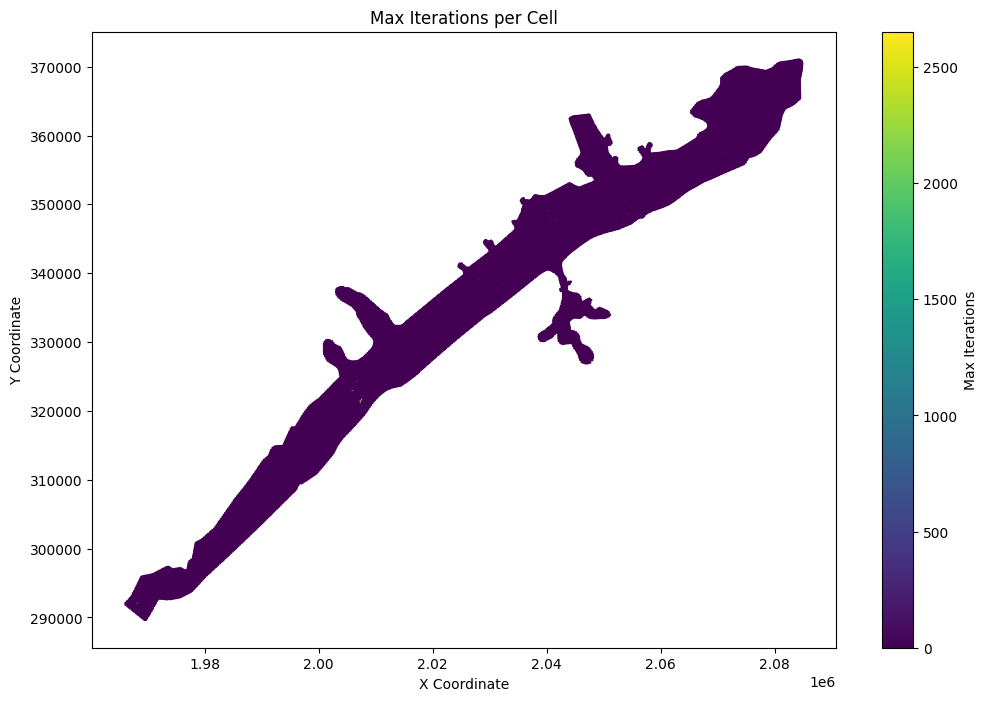


First few rows of the dataframe:


,mesh_name,cell_id,geometry
0,BaldEagleCr,0,POINT (2083000 370750)
1,BaldEagleCr,1,POINT (2083250 370750)
2,BaldEagleCr,2,POINT (2083500 370750)
3,BaldEagleCr,3,POINT (2083750 370750)
4,BaldEagleCr,4,POINT (2084000 370750)
...,...,...,...
19592,BaldEagleCr,19592,POINT (1978423.032 300718.897)
19593,BaldEagleCr,19593,POINT (1973389.375 297311.928)
19594,BaldEagleCr,19594,POINT (1968834.79 295808.861)
19595,BaldEagleCr,19595,POINT (1966130.942 291879.395)


In [41]:
# Plot Mesh Max Iterations

# Extract x and y coordinates from the geometry column
max_iter_df['x'] = max_iter_df['geometry'].apply(lambda geom: geom.x if geom is not None else None)
max_iter_df['y'] = max_iter_df['geometry'].apply(lambda geom: geom.y if geom is not None else None)

# Remove rows with None coordinates
max_iter_df = max_iter_df.dropna(subset=['x', 'y'])

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(max_iter_df['x'], max_iter_df['y'], 
                     c=max_iter_df['cell_last_iteration'], 
                     cmap='viridis', 
                     s=1)

# Customize the plot
ax.set_title('Max Iterations per Cell')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
plt.colorbar(scatter, label='Max Iterations')

# Show the plot
plt.show()

# Print the first few rows of the dataframe for verification
print("\nFirst few rows of the dataframe:")
max_iter_df[['mesh_name', 'cell_id', 'geometry']]

In [42]:
# Example: Get mesh maximum water surface elevation
max_ws_df = HdfResultsMesh.get_mesh_max_ws(plan_hdf_path)
print("\nMesh Maximum Water Surface Elevation:")
print(max_ws_df.attrs)
max_ws_df

2025-03-15 08:42:49 - ras_commander.HdfResultsMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:49 - ras_commander.HdfResultsMesh - INFO - Processing summary output for variable: Maximum Water Surface
2025-03-15 08:42:49 - ras_commander.HdfMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:49 - ras_commander.HdfMesh - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:49 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:49 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:49 - ras_commander.HdfBase - INFO - 


Mesh Maximum Water Surface Elevation:
{'mesh_name': 'BaldEagleCr', 'Max Time': np.float32(5.0), 'Max Value': np.float32(848.2054), 'Min Time': np.float32(0.99953705), 'Min Value': np.float32(535.585), 'Rows Variables': [b'WSEL', b'Time'], 'Units': [b'ft', b'days']}


,mesh_name,cell_id,maximum_water_surface,maximum_water_surface_time,geometry
0,BaldEagleCr,0,704.054443,2018-09-10 18:00:00,POINT (2083000 370750)
1,BaldEagleCr,1,692.377991,2018-09-10 18:04:00,POINT (2083250 370750)
2,BaldEagleCr,2,671.183472,2018-09-10 18:13:20,POINT (2083500 370750)
3,BaldEagleCr,3,660.605469,2018-09-10 18:54:40,POINT (2083750 370750)
4,BaldEagleCr,4,660.586243,2018-09-10 18:55:20,POINT (2084000 370750)
...,...,...,...,...,...
19592,BaldEagleCr,19592,0.000000,2018-09-09 00:00:00,POINT (1978423.032 300718.897)
19593,BaldEagleCr,19593,0.000000,2018-09-09 00:00:00,POINT (1973389.375 297311.928)
19594,BaldEagleCr,19594,0.000000,2018-09-09 00:00:00,POINT (1968834.79 295808.861)
19595,BaldEagleCr,19595,0.000000,2018-09-09 00:00:00,POINT (1966130.942 291879.395)


max_ws_df:

| mesh_name | cell_id | maximum_water_surface | maximum_water_surface_time | geometry |
|-----------|---------|---------------------|--------------------------|-----------|
| BaldEagleCr | 0 | 704.054443 | 2018-09-10 18:00:00 | POINT (2083000 370750) |
| BaldEagleCr | 1 | 692.377991 | 2018-09-10 18:04:00 | POINT (2083250 370750) |

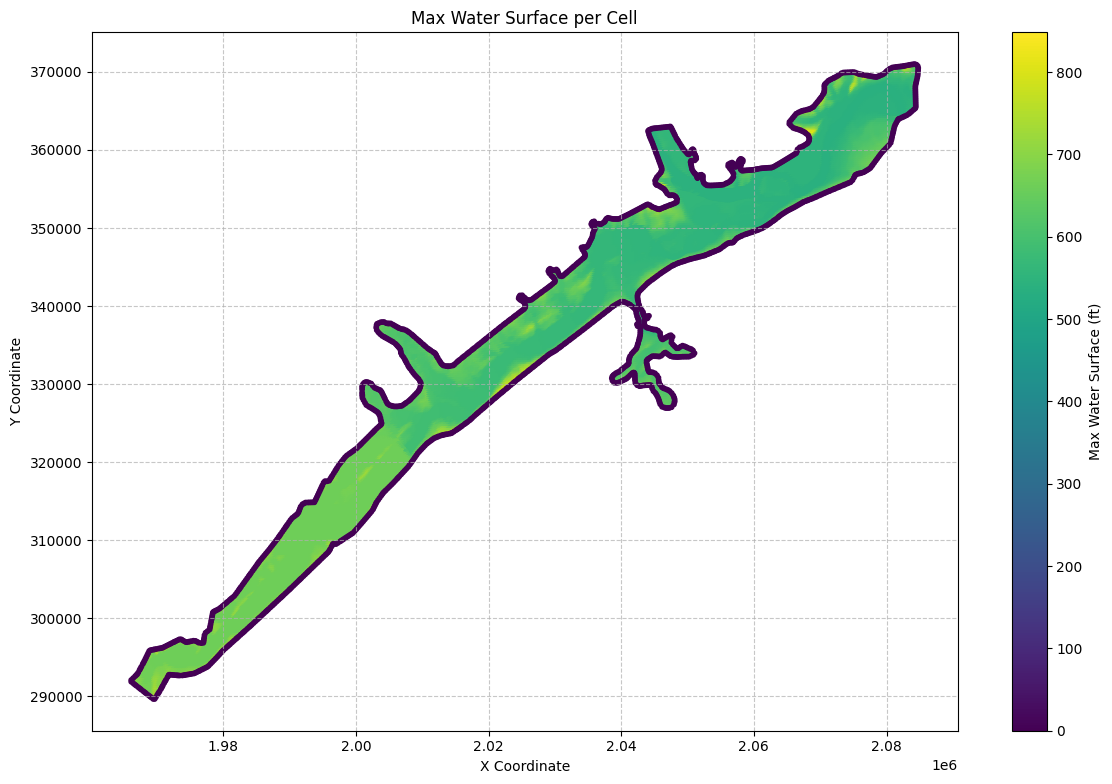


First few rows of the dataframe:


,mesh_name,cell_id,maximum_water_surface,maximum_water_surface_time,geometry,x,y
0,BaldEagleCr,0,704.054443,2018-09-10 18:00:00,POINT (2083000 370750),2.083000e+06,370750.000000
1,BaldEagleCr,1,692.377991,2018-09-10 18:04:00,POINT (2083250 370750),2.083250e+06,370750.000000
2,BaldEagleCr,2,671.183472,2018-09-10 18:13:20,POINT (2083500 370750),2.083500e+06,370750.000000
3,BaldEagleCr,3,660.605469,2018-09-10 18:54:40,POINT (2083750 370750),2.083750e+06,370750.000000
4,BaldEagleCr,4,660.586243,2018-09-10 18:55:20,POINT (2084000 370750),2.084000e+06,370750.000000
...,...,...,...,...,...,...,...
19592,BaldEagleCr,19592,0.000000,2018-09-09 00:00:00,POINT (1978423.032 300718.897),1.978423e+06,300718.897016
19593,BaldEagleCr,19593,0.000000,2018-09-09 00:00:00,POINT (1973389.375 297311.928),1.973389e+06,297311.928472
19594,BaldEagleCr,19594,0.000000,2018-09-09 00:00:00,POINT (1968834.79 295808.861),1.968835e+06,295808.860743
19595,BaldEagleCr,19595,0.000000,2018-09-09 00:00:00,POINT (1966130.942 291879.395),1.966131e+06,291879.394946


In [43]:
# Plot the max water surface as a map
import matplotlib.pyplot as plt
from ras_commander.HdfResultsMesh import HdfResultsMesh

# Extract x and y coordinates from the geometry column
max_ws_df['x'] = max_ws_df['geometry'].apply(lambda geom: geom.x if geom is not None else None)
max_ws_df['y'] = max_ws_df['geometry'].apply(lambda geom: geom.y if geom is not None else None)

# Remove rows with None coordinates
max_ws_df = max_ws_df.dropna(subset=['x', 'y'])

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(max_ws_df['x'], max_ws_df['y'], 
                     c=max_ws_df['maximum_water_surface'], 
                     cmap='viridis', 
                     s=10)

# Customize the plot
ax.set_title('Max Water Surface per Cell')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
plt.colorbar(scatter, label='Max Water Surface (ft)')

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# Increase font size for better readability
plt.rcParams.update({'font.size': 12})

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

# Print the first few rows of the dataframe for verification
print("\nFirst few rows of the dataframe:")
max_ws_df

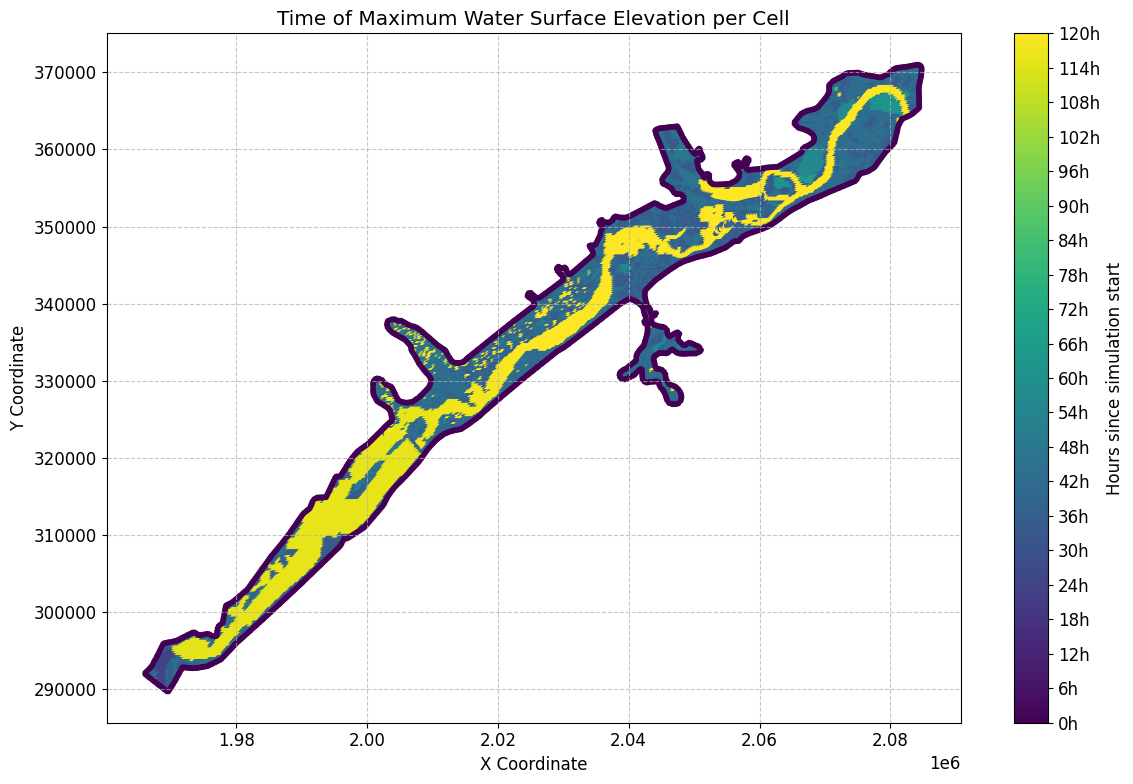


Overall Maximum WSEL: 848.21 ft
Time of Overall Maximum WSEL: 2018-09-10 17:00:00
Hours since simulation start: 41.00 hours
Location of Overall Maximum WSEL: X=1968500.0, Y=295000.0


In [44]:
# Plot the time of the max water surface elevation (WSEL)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Convert the 'maximum_water_surface_time' to datetime objects
max_ws_df['max_wsel_time'] = pd.to_datetime(max_ws_df['maximum_water_surface_time'])

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Convert datetime to hours since the start for colormap
min_time = max_ws_df['max_wsel_time'].min()
color_values = (max_ws_df['max_wsel_time'] - min_time).dt.total_seconds() / 3600  # Convert to hours

scatter = ax.scatter(max_ws_df['x'], max_ws_df['y'], 
                     c=color_values, 
                     cmap='viridis', 
                     s=10)

# Customize the plot
ax.set_title('Time of Maximum Water Surface Elevation per Cell')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

# Set up the colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Hours since simulation start')

# Format the colorbar ticks to show hours
cbar.set_ticks(range(0, int(color_values.max()) + 1, 6))  # Set ticks every 6 hours
cbar.set_ticklabels([f'{h}h' for h in range(0, int(color_values.max()) + 1, 6)])

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# Increase font size for better readability
plt.rcParams.update({'font.size': 12})

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

# Find the overall maximum WSEL and its time
max_wsel_row = max_ws_df.loc[max_ws_df['maximum_water_surface'].idxmax()]
hours_since_start = (max_wsel_row['max_wsel_time'] - min_time).total_seconds() / 3600
print(f"\nOverall Maximum WSEL: {max_wsel_row['maximum_water_surface']:.2f} ft")
print(f"Time of Overall Maximum WSEL: {max_wsel_row['max_wsel_time']}")
print(f"Hours since simulation start: {hours_since_start:.2f} hours")
print(f"Location of Overall Maximum WSEL: X={max_wsel_row['x']}, Y={max_wsel_row['y']}")


In [45]:
# Example: Get mesh minimum water surface elevation
min_ws_df = HdfResultsMesh.get_mesh_min_ws(plan_hdf_path)
print("\nMesh Minimum Water Surface Elevation:")
min_ws_df

2025-03-15 08:42:51 - ras_commander.HdfResultsMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:51 - ras_commander.HdfResultsMesh - INFO - Processing summary output for variable: Minimum Water Surface
2025-03-15 08:42:51 - ras_commander.HdfMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:51 - ras_commander.HdfMesh - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:51 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:51 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:51 - ras_commander.HdfBase - INFO - 


Mesh Minimum Water Surface Elevation:


,mesh_name,cell_id,minimum_water_surface,minimum_water_surface_time,geometry
0,BaldEagleCr,0,701.151245,2018-09-09 00:00:20,POINT (2083000 370750)
1,BaldEagleCr,1,689.052246,2018-09-09 00:00:20,POINT (2083250 370750)
2,BaldEagleCr,2,669.774719,2018-09-09 00:00:20,POINT (2083500 370750)
3,BaldEagleCr,3,658.986938,2018-09-09 00:00:20,POINT (2083750 370750)
4,BaldEagleCr,4,658.720581,2018-09-09 00:00:20,POINT (2084000 370750)
...,...,...,...,...,...
19592,BaldEagleCr,19592,0.000000,2018-09-09 00:00:00,POINT (1978423.032 300718.897)
19593,BaldEagleCr,19593,0.000000,2018-09-09 00:00:00,POINT (1973389.375 297311.928)
19594,BaldEagleCr,19594,0.000000,2018-09-09 00:00:00,POINT (1968834.79 295808.861)
19595,BaldEagleCr,19595,0.000000,2018-09-09 00:00:00,POINT (1966130.942 291879.395)


In [46]:
# Example: Get mesh maximum face velocity
max_face_v_df = HdfResultsMesh.get_mesh_max_face_v(plan_hdf_path)
print("\nMesh Max Face Velocity:")
max_face_v_df

2025-03-15 08:42:51 - ras_commander.HdfResultsMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:51 - ras_commander.HdfResultsMesh - INFO - Processing summary output for variable: Maximum Face Velocity
2025-03-15 08:42:51 - ras_commander.HdfMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:51 - ras_commander.HdfMesh - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:52 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:52 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:52 - ras_commander.HdfBase - INFO - 


Mesh Max Face Velocity:


,mesh_name,face_id,maximum_face_velocity,maximum_face_velocity_time,geometry
0,BaldEagleCr,0,0.451430,2018-09-10 18:00:00,"LINESTRING (2042125 351625, 2042375 351625)"
1,BaldEagleCr,1,-0.887190,2018-09-10 18:00:40,"LINESTRING (2042375 351625, 2042375 351875)"
2,BaldEagleCr,2,-0.498561,2018-09-10 18:00:40,"LINESTRING (2042375 351875, 2042125 351875)"
3,BaldEagleCr,3,-0.304673,2018-09-10 18:00:40,"LINESTRING (2042125 351875, 2042125 351625)"
4,BaldEagleCr,4,-0.762405,2018-09-10 10:00:40,"LINESTRING (2042375 351375, 2042375 351625)"
...,...,...,...,...,...
37589,BaldEagleCr,37589,0.000000,2018-09-09 00:00:00,"LINESTRING (1978444.054 300812.794, 1978402.01..."
37590,BaldEagleCr,37590,0.000000,2018-09-09 00:00:00,"LINESTRING (1973531.76 297370.846, 1973246.989..."
37591,BaldEagleCr,37591,0.000000,2018-09-09 00:00:00,"LINESTRING (1968886.801 295900.5, 1968782.778 ..."
37592,BaldEagleCr,37592,0.000000,2018-09-09 00:00:00,"LINESTRING (1965981.775 291978.68, 1966280.11 ..."


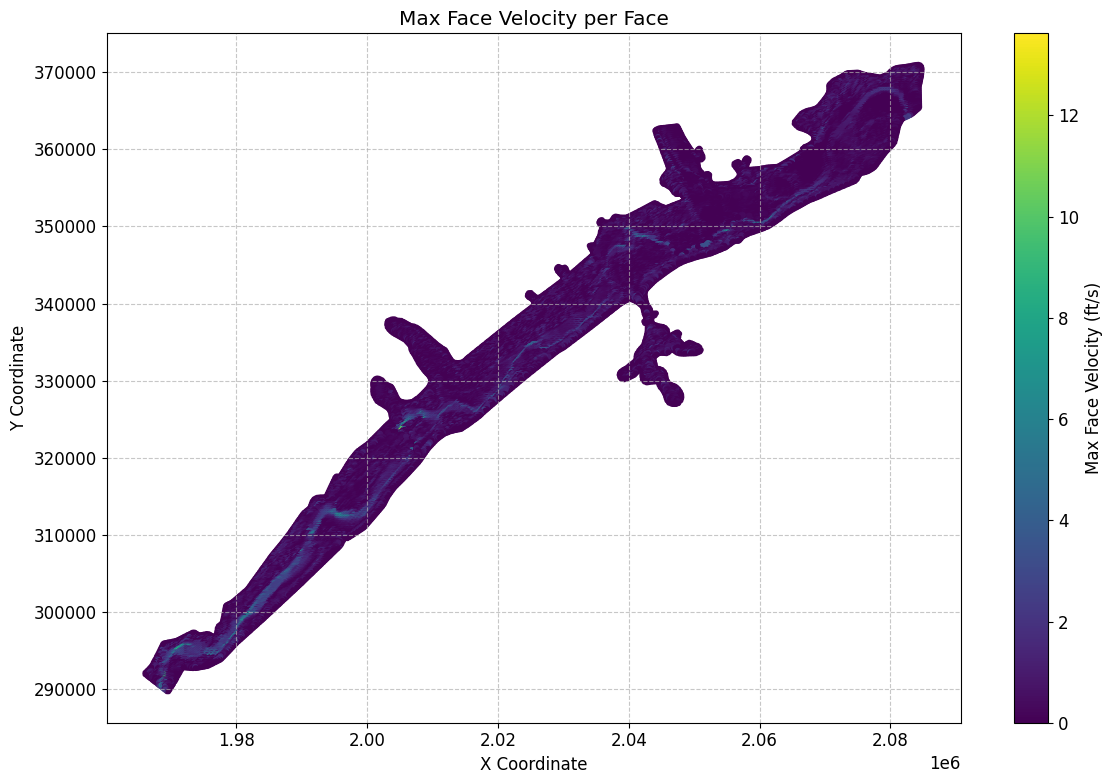


First few rows of the face velocity dataframe:


,mesh_name,face_id,maximum_face_velocity,maximum_face_velocity_time,geometry,x,y
0,BaldEagleCr,0,0.451430,2018-09-10 18:00:00,"LINESTRING (2042125 351625, 2042375 351625)",2.042250e+06,351625.000000
1,BaldEagleCr,1,-0.887190,2018-09-10 18:00:40,"LINESTRING (2042375 351625, 2042375 351875)",2.042375e+06,351750.000000
2,BaldEagleCr,2,-0.498561,2018-09-10 18:00:40,"LINESTRING (2042375 351875, 2042125 351875)",2.042250e+06,351875.000000
3,BaldEagleCr,3,-0.304673,2018-09-10 18:00:40,"LINESTRING (2042125 351875, 2042125 351625)",2.042125e+06,351750.000000
4,BaldEagleCr,4,-0.762405,2018-09-10 10:00:40,"LINESTRING (2042375 351375, 2042375 351625)",2.042375e+06,351500.000000
...,...,...,...,...,...,...,...
37589,BaldEagleCr,37589,0.000000,2018-09-09 00:00:00,"LINESTRING (1978444.054 300812.794, 1978402.01...",1.978423e+06,300718.897016
37590,BaldEagleCr,37590,0.000000,2018-09-09 00:00:00,"LINESTRING (1973531.76 297370.846, 1973246.989...",1.973389e+06,297311.928472
37591,BaldEagleCr,37591,0.000000,2018-09-09 00:00:00,"LINESTRING (1968886.801 295900.5, 1968782.778 ...",1.968835e+06,295808.860743
37592,BaldEagleCr,37592,0.000000,2018-09-09 00:00:00,"LINESTRING (1965981.775 291978.68, 1966280.11 ...",1.966131e+06,291879.394946


In [47]:
# Extract midpoint coordinates from the LineString geometries
max_face_v_df['x'] = max_face_v_df['geometry'].apply(lambda geom: geom.centroid.x)
max_face_v_df['y'] = max_face_v_df['geometry'].apply(lambda geom: geom.centroid.y)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(max_face_v_df['x'], max_face_v_df['y'], 
                    c=max_face_v_df['maximum_face_velocity'].abs(),
                    cmap='viridis',
                    s=10)

# Customize the plot
ax.set_title('Max Face Velocity per Face')
ax.set_xlabel('X Coordinate') 
ax.set_ylabel('Y Coordinate')
plt.colorbar(scatter, label='Max Face Velocity (ft/s)')

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# Increase font size for better readability
plt.rcParams.update({'font.size': 12})

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

# Print the first few rows of the dataframe for verification
print("\nFirst few rows of the face velocity dataframe:")
max_face_v_df

In [48]:
# Example: Get mesh minimum face velocity
min_face_v_df = HdfResultsMesh.get_mesh_min_face_v(plan_hdf_path)
print("\nMesh Min Face Velocity:")
min_face_v_df


2025-03-15 08:42:54 - ras_commander.HdfResultsMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:54 - ras_commander.HdfResultsMesh - INFO - Processing summary output for variable: Minimum Face Velocity
2025-03-15 08:42:54 - ras_commander.HdfMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:54 - ras_commander.HdfMesh - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:54 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:54 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:54 - ras_commander.HdfBase - INFO - 


Mesh Min Face Velocity:


,mesh_name,face_id,minimum_face_velocity,minimum_face_velocity_time,geometry
0,BaldEagleCr,0,0.0,2018-09-09 00:00:20,"LINESTRING (2042125 351625, 2042375 351625)"
1,BaldEagleCr,1,0.0,2018-09-09 00:00:20,"LINESTRING (2042375 351625, 2042375 351875)"
2,BaldEagleCr,2,0.0,2018-09-09 00:00:20,"LINESTRING (2042375 351875, 2042125 351875)"
3,BaldEagleCr,3,0.0,2018-09-09 00:00:20,"LINESTRING (2042125 351875, 2042125 351625)"
4,BaldEagleCr,4,0.0,2018-09-09 00:00:20,"LINESTRING (2042375 351375, 2042375 351625)"
...,...,...,...,...,...
37589,BaldEagleCr,37589,0.0,2018-09-09 00:00:20,"LINESTRING (1978444.054 300812.794, 1978402.01..."
37590,BaldEagleCr,37590,0.0,2018-09-09 00:00:20,"LINESTRING (1973531.76 297370.846, 1973246.989..."
37591,BaldEagleCr,37591,0.0,2018-09-09 00:00:20,"LINESTRING (1968886.801 295900.5, 1968782.778 ..."
37592,BaldEagleCr,37592,0.0,2018-09-09 00:00:20,"LINESTRING (1965981.775 291978.68, 1966280.11 ..."


In [49]:
# Example: Get mesh max water surface error

max_ws_err_df = HdfResultsMesh.get_mesh_max_ws_err(plan_hdf_path)
print("\nMesh Max Water Surface Error:")
max_ws_err_df


2025-03-15 08:42:55 - ras_commander.HdfResultsMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:55 - ras_commander.HdfResultsMesh - INFO - Processing summary output for variable: Cell Maximum Water Surface Error
2025-03-15 08:42:55 - ras_commander.HdfMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:55 - ras_commander.HdfMesh - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:55 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:55 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:55 - ras_commander.HdfBas


Mesh Max Water Surface Error:


,mesh_name,cell_id,cell_maximum_water_surface_error,cell_maximum_water_surface_error_time,geometry
0,BaldEagleCr,0,0.000206,2018-09-11 20:50:00,POINT (2083000 370750)
1,BaldEagleCr,1,0.001100,2018-09-10 21:38:00,POINT (2083250 370750)
2,BaldEagleCr,2,0.000795,2018-09-10 09:58:40,POINT (2083500 370750)
3,BaldEagleCr,3,0.000314,2018-09-10 17:00:40,POINT (2083750 370750)
4,BaldEagleCr,4,0.001795,2018-09-10 09:28:00,POINT (2084000 370750)
...,...,...,...,...,...
19592,BaldEagleCr,19592,0.000000,2018-09-09 00:00:00,POINT (1978423.032 300718.897)
19593,BaldEagleCr,19593,0.000000,2018-09-09 00:00:00,POINT (1973389.375 297311.928)
19594,BaldEagleCr,19594,0.000000,2018-09-09 00:00:00,POINT (1968834.79 295808.861)
19595,BaldEagleCr,19595,0.000000,2018-09-09 00:00:00,POINT (1966130.942 291879.395)


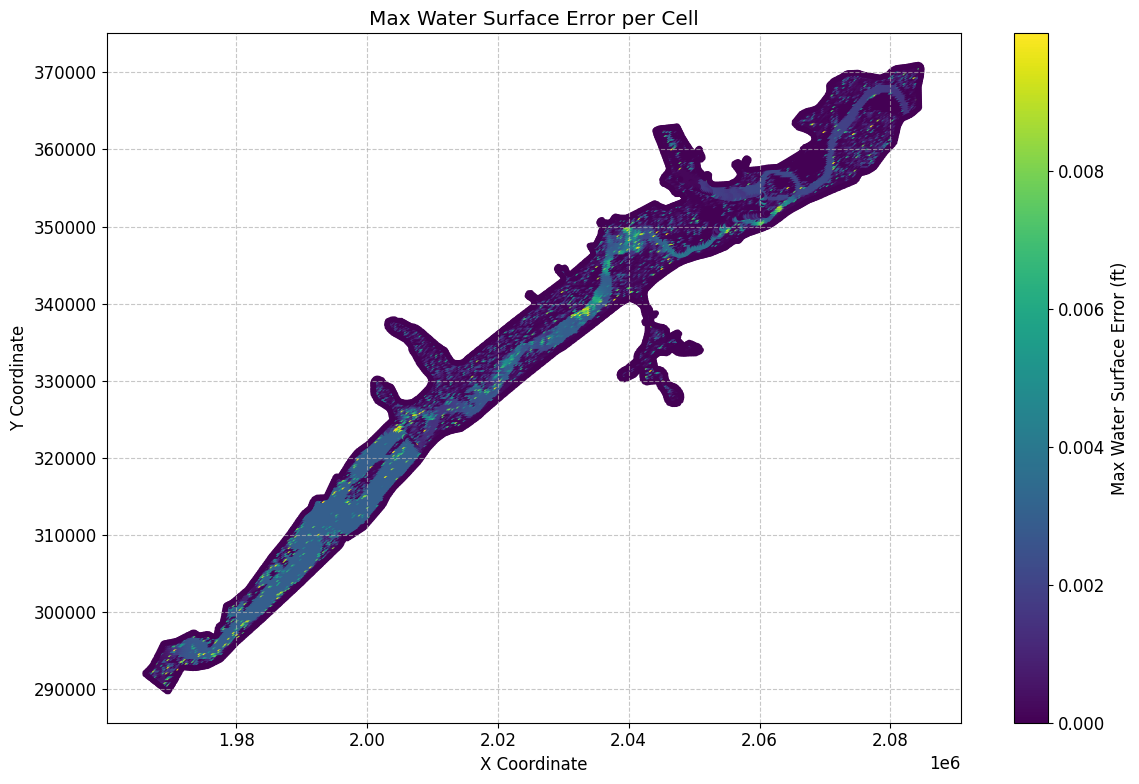


First few rows of the water surface error dataframe:


,mesh_name,cell_id,cell_maximum_water_surface_error,cell_maximum_water_surface_error_time,geometry,x,y
0,BaldEagleCr,0,0.000206,2018-09-11 20:50:00,POINT (2083000 370750),2.083000e+06,370750.000000
1,BaldEagleCr,1,0.001100,2018-09-10 21:38:00,POINT (2083250 370750),2.083250e+06,370750.000000
2,BaldEagleCr,2,0.000795,2018-09-10 09:58:40,POINT (2083500 370750),2.083500e+06,370750.000000
3,BaldEagleCr,3,0.000314,2018-09-10 17:00:40,POINT (2083750 370750),2.083750e+06,370750.000000
4,BaldEagleCr,4,0.001795,2018-09-10 09:28:00,POINT (2084000 370750),2.084000e+06,370750.000000
...,...,...,...,...,...,...,...
19592,BaldEagleCr,19592,0.000000,2018-09-09 00:00:00,POINT (1978423.032 300718.897),1.978423e+06,300718.897016
19593,BaldEagleCr,19593,0.000000,2018-09-09 00:00:00,POINT (1973389.375 297311.928),1.973389e+06,297311.928472
19594,BaldEagleCr,19594,0.000000,2018-09-09 00:00:00,POINT (1968834.79 295808.861),1.968835e+06,295808.860743
19595,BaldEagleCr,19595,0.000000,2018-09-09 00:00:00,POINT (1966130.942 291879.395),1.966131e+06,291879.394946


In [50]:
# Plot max water surface error
import matplotlib.pyplot as plt

# Extract x and y coordinates from the geometry points, handling None values
max_ws_err_df['x'] = max_ws_err_df['geometry'].apply(lambda geom: geom.x if geom is not None else None)
max_ws_err_df['y'] = max_ws_err_df['geometry'].apply(lambda geom: geom.y if geom is not None else None)

# Remove any rows with None coordinates
max_ws_err_df = max_ws_err_df.dropna(subset=['x', 'y'])

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(max_ws_err_df['x'], max_ws_err_df['y'],
                    c=max_ws_err_df['cell_maximum_water_surface_error'],
                    cmap='viridis',
                    s=10)

# Customize the plot
ax.set_title('Max Water Surface Error per Cell')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
plt.colorbar(scatter, label='Max Water Surface Error (ft)')

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# Increase font size for better readability
plt.rcParams.update({'font.size': 12})

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

# Print the first few rows of the dataframe for verification
print("\nFirst few rows of the water surface error dataframe:")
max_ws_err_df

### Need to add this to the ras-commander library

In [51]:
# Example: Get mesh summary output for other Datasets (here we retrieve Maximum Face Courant)
max_courant_df = HdfResultsMesh.get_mesh_summary(plan_hdf_path, var="Maximum Face Courant")
print("\nMesh Summary Output (Maximum Courant):")
print(max_courant_df.attrs)
max_courant_df


2025-03-15 08:42:56 - ras_commander.HdfResultsMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:56 - ras_commander.HdfResultsMesh - INFO - Processing summary output for variable: Maximum Face Courant
2025-03-15 08:42:56 - ras_commander.HdfMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:56 - ras_commander.HdfMesh - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:56 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:56 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:56 - ras_commander.HdfBase - INFO - U


Mesh Summary Output (Maximum Courant):
{'mesh_name': 'BaldEagleCr', 'Can Interpolate': 'False', 'Can Plot': 'True', 'Coverage': 'Average', 'Location': 'Faces', 'Maximum Value of Data Set': np.float32(0.6819884), 'Minimum Value of Data Set': np.float32(0.0), 'Name': 'Face Courant Maximum', 'Orientation': 'Scalar', 'Row': np.int32(0), 'Rows Variables': [b'Courant Face', b'Time'], 'Units': 'vel*dt/length', 'Units per row': [b'vel*dt/length', b'days']}


,mesh_name,face_id,maximum_face_courant,maximum_face_courant_time,geometry
0,BaldEagleCr,0,0.000020,2018-09-09 11:03:20,"LINESTRING (2042125 351625, 2042375 351625)"
1,BaldEagleCr,1,0.000062,2018-09-09 11:32:40,"LINESTRING (2042375 351625, 2042375 351875)"
2,BaldEagleCr,2,0.000048,2018-09-10 07:02:40,"LINESTRING (2042375 351875, 2042125 351875)"
3,BaldEagleCr,3,0.000016,2018-09-09 11:03:20,"LINESTRING (2042125 351875, 2042125 351625)"
4,BaldEagleCr,4,0.000062,2018-09-09 11:05:20,"LINESTRING (2042375 351375, 2042375 351625)"
...,...,...,...,...,...
37589,BaldEagleCr,37589,0.000000,2018-09-09 00:00:00,"LINESTRING (1978444.054 300812.794, 1978402.01..."
37590,BaldEagleCr,37590,0.000000,2018-09-09 00:00:00,"LINESTRING (1973531.76 297370.846, 1973246.989..."
37591,BaldEagleCr,37591,0.000000,2018-09-09 00:00:00,"LINESTRING (1968886.801 295900.5, 1968782.778 ..."
37592,BaldEagleCr,37592,0.000000,2018-09-09 00:00:00,"LINESTRING (1965981.775 291978.68, 1966280.11 ..."


2025-03-15 08:42:56 - ras_commander.HdfResultsMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:56 - ras_commander.HdfResultsMesh - INFO - Processing summary output for variable: Maximum Face Courant
2025-03-15 08:42:57 - ras_commander.HdfMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:57 - ras_commander.HdfMesh - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:57 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:57 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:57 - ras_commander.HdfBase - INFO - U

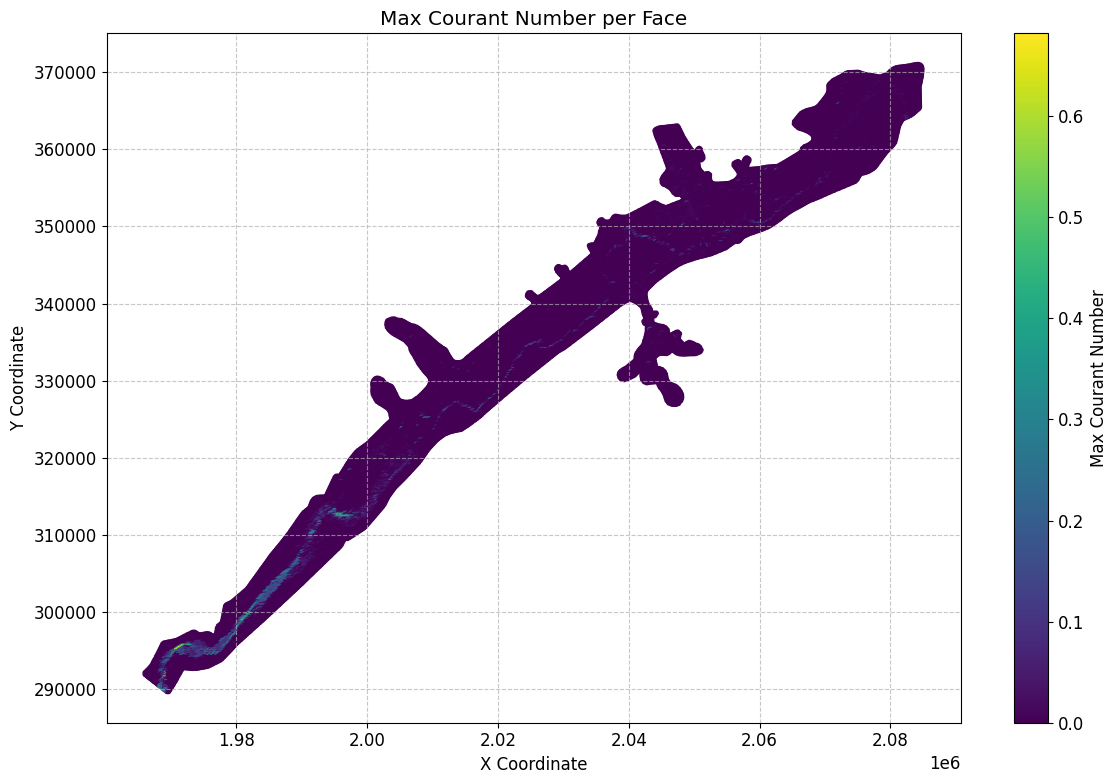


First few rows of the Courant number dataframe:


,mesh_name,face_id,maximum_face_courant,maximum_face_courant_time,geometry,centroid,x,y
0,BaldEagleCr,0,0.000020,2018-09-09 11:03:20,"LINESTRING (2042125 351625, 2042375 351625)",POINT (2042250 351625),2.042250e+06,351625.000000
1,BaldEagleCr,1,0.000062,2018-09-09 11:32:40,"LINESTRING (2042375 351625, 2042375 351875)",POINT (2042375 351750),2.042375e+06,351750.000000
2,BaldEagleCr,2,0.000048,2018-09-10 07:02:40,"LINESTRING (2042375 351875, 2042125 351875)",POINT (2042250 351875),2.042250e+06,351875.000000
3,BaldEagleCr,3,0.000016,2018-09-09 11:03:20,"LINESTRING (2042125 351875, 2042125 351625)",POINT (2042125 351750),2.042125e+06,351750.000000
4,BaldEagleCr,4,0.000062,2018-09-09 11:05:20,"LINESTRING (2042375 351375, 2042375 351625)",POINT (2042375 351500),2.042375e+06,351500.000000
...,...,...,...,...,...,...,...,...
37589,BaldEagleCr,37589,0.000000,2018-09-09 00:00:00,"LINESTRING (1978444.054 300812.794, 1978402.01...",POINT (1978423.032 300718.897),1.978423e+06,300718.897016
37590,BaldEagleCr,37590,0.000000,2018-09-09 00:00:00,"LINESTRING (1973531.76 297370.846, 1973246.989...",POINT (1973389.375 297311.928),1.973389e+06,297311.928472
37591,BaldEagleCr,37591,0.000000,2018-09-09 00:00:00,"LINESTRING (1968886.801 295900.5, 1968782.778 ...",POINT (1968834.79 295808.861),1.968835e+06,295808.860743
37592,BaldEagleCr,37592,0.000000,2018-09-09 00:00:00,"LINESTRING (1965981.775 291978.68, 1966280.11 ...",POINT (1966130.942 291879.395),1.966131e+06,291879.394946


In [52]:
# Plot max Courant number
import matplotlib.pyplot as plt
from ras_commander.HdfMesh import HdfMesh
from ras_commander.HdfResultsMesh import HdfResultsMesh
from shapely.geometry import LineString
import geopandas as gpd

# Get mesh max Courant number
max_courant_df = HdfResultsMesh.get_mesh_summary(plan_hdf_path, var="Maximum Face Courant")

# Convert to GeoDataFrame
max_courant_gdf = gpd.GeoDataFrame(max_courant_df)

# Get centroids of line geometries for plotting
max_courant_gdf['centroid'] = max_courant_gdf.geometry.centroid
max_courant_gdf['x'] = max_courant_gdf.centroid.x
max_courant_gdf['y'] = max_courant_gdf.centroid.y

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(max_courant_gdf['x'], max_courant_gdf['y'],
                    c=max_courant_gdf['maximum_face_courant'],
                    cmap='viridis',
                    s=10)

# Customize the plot
ax.set_title('Max Courant Number per Face')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
plt.colorbar(scatter, label='Max Courant Number')

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# Increase font size for better readability
plt.rcParams.update({'font.size': 12})

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

# Print the first few rows of the dataframe for verification
print("\nFirst few rows of the Courant number dataframe:")
max_courant_gdf


In [53]:
# Example: Get mesh summary output for other Datasets (here we retrieve Maximum Face Courant)

max_face_shear_df = HdfResultsMesh.get_mesh_summary(plan_hdf_path, var="Maximum Face Shear Stress")
print("\nMesh Summary Output (Maximum Face Shear Stress:")
print(max_face_shear_df.attrs)
max_face_shear_df


2025-03-15 08:42:58 - ras_commander.HdfResultsMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:58 - ras_commander.HdfResultsMesh - INFO - Processing summary output for variable: Maximum Face Shear Stress
2025-03-15 08:42:59 - ras_commander.HdfMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:59 - ras_commander.HdfMesh - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:59 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:59 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:59 - ras_commander.HdfBase - INF


Mesh Summary Output (Maximum Face Shear Stress:
{'mesh_name': 'BaldEagleCr', 'Max Time': np.float32(0.0), 'Max Value': np.float32(0.0), 'Min Time': np.float32(0.0), 'Min Value': np.float32(0.0), 'Rows Variables': [b'Shear Stress', b'Time'], 'Units': [b'PSF', b'days']}


,mesh_name,face_id,maximum_face_shear_stress,maximum_face_shear_stress_time,geometry
0,BaldEagleCr,0,0.0,2018-09-09,"LINESTRING (2042125 351625, 2042375 351625)"
1,BaldEagleCr,1,0.0,2018-09-09,"LINESTRING (2042375 351625, 2042375 351875)"
2,BaldEagleCr,2,0.0,2018-09-09,"LINESTRING (2042375 351875, 2042125 351875)"
3,BaldEagleCr,3,0.0,2018-09-09,"LINESTRING (2042125 351875, 2042125 351625)"
4,BaldEagleCr,4,0.0,2018-09-09,"LINESTRING (2042375 351375, 2042375 351625)"
...,...,...,...,...,...
37589,BaldEagleCr,37589,0.0,2018-09-09,"LINESTRING (1978444.054 300812.794, 1978402.01..."
37590,BaldEagleCr,37590,0.0,2018-09-09,"LINESTRING (1973531.76 297370.846, 1973246.989..."
37591,BaldEagleCr,37591,0.0,2018-09-09,"LINESTRING (1968886.801 295900.5, 1968782.778 ..."
37592,BaldEagleCr,37592,0.0,2018-09-09,"LINESTRING (1965981.775 291978.68, 1966280.11 ..."


2025-03-15 08:42:59 - ras_commander.HdfResultsMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:59 - ras_commander.HdfResultsMesh - INFO - Processing summary output for variable: Maximum Face Shear Stress
2025-03-15 08:42:59 - ras_commander.HdfMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:42:59 - ras_commander.HdfMesh - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:43:00 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:43:00 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:43:00 - ras_commander.HdfBase - INF

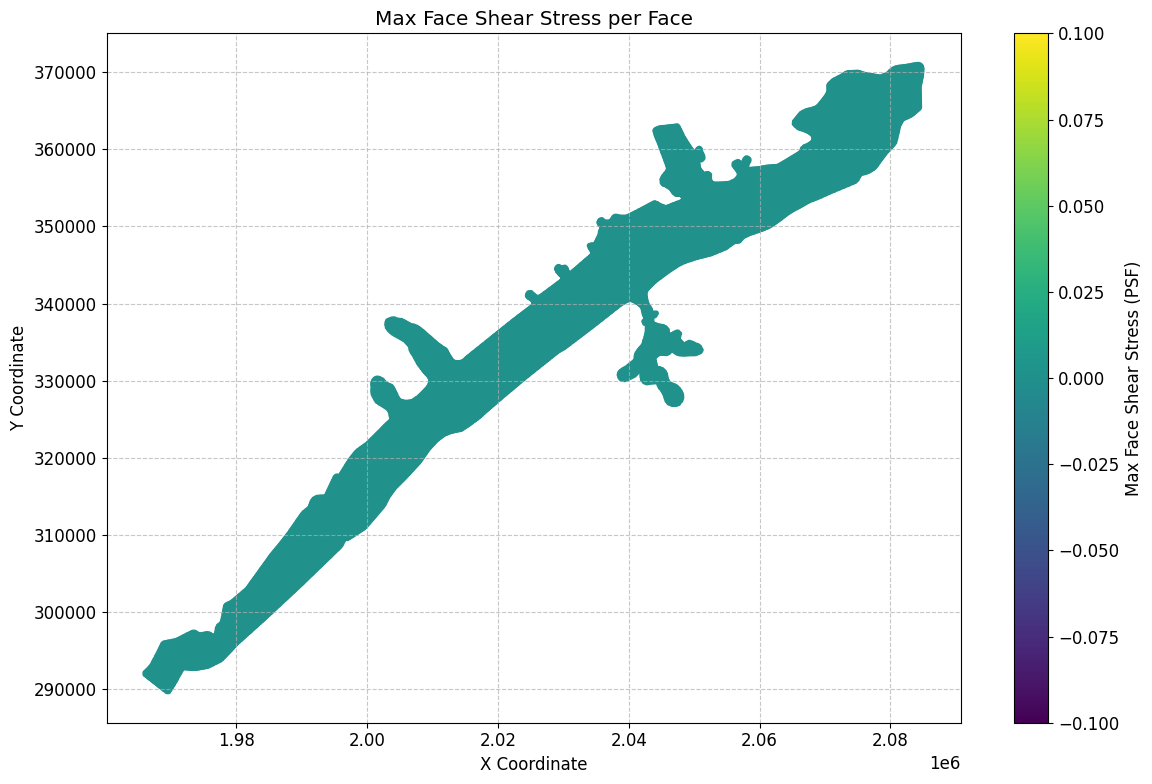


First few rows of the shear stress dataframe:


,mesh_name,face_id,maximum_face_shear_stress,maximum_face_shear_stress_time,geometry,centroid,x,y
0,BaldEagleCr,0,0.0,2018-09-09,"LINESTRING (2042125 351625, 2042375 351625)",POINT (2042250 351625),2.042250e+06,351625.000000
1,BaldEagleCr,1,0.0,2018-09-09,"LINESTRING (2042375 351625, 2042375 351875)",POINT (2042375 351750),2.042375e+06,351750.000000
2,BaldEagleCr,2,0.0,2018-09-09,"LINESTRING (2042375 351875, 2042125 351875)",POINT (2042250 351875),2.042250e+06,351875.000000
3,BaldEagleCr,3,0.0,2018-09-09,"LINESTRING (2042125 351875, 2042125 351625)",POINT (2042125 351750),2.042125e+06,351750.000000
4,BaldEagleCr,4,0.0,2018-09-09,"LINESTRING (2042375 351375, 2042375 351625)",POINT (2042375 351500),2.042375e+06,351500.000000
...,...,...,...,...,...,...,...,...
37589,BaldEagleCr,37589,0.0,2018-09-09,"LINESTRING (1978444.054 300812.794, 1978402.01...",POINT (1978423.032 300718.897),1.978423e+06,300718.897016
37590,BaldEagleCr,37590,0.0,2018-09-09,"LINESTRING (1973531.76 297370.846, 1973246.989...",POINT (1973389.375 297311.928),1.973389e+06,297311.928472
37591,BaldEagleCr,37591,0.0,2018-09-09,"LINESTRING (1968886.801 295900.5, 1968782.778 ...",POINT (1968834.79 295808.861),1.968835e+06,295808.860743
37592,BaldEagleCr,37592,0.0,2018-09-09,"LINESTRING (1965981.775 291978.68, 1966280.11 ...",POINT (1966130.942 291879.395),1.966131e+06,291879.394946


In [54]:
# Plot max face shear stress
import matplotlib.pyplot as plt
from ras_commander.HdfMesh import HdfMesh
from ras_commander.HdfResultsMesh import HdfResultsMesh
from shapely.geometry import Point, LineString
import geopandas as gpd

# Get mesh max face shear stress
max_shear_df = HdfResultsMesh.get_mesh_summary(plan_hdf_path, var="Maximum Face Shear Stress")

# Calculate centroids of the line geometries and extract coordinates
max_shear_df['centroid'] = max_shear_df['geometry'].apply(lambda line: line.centroid)
max_shear_df['x'] = max_shear_df['centroid'].apply(lambda point: point.x)
max_shear_df['y'] = max_shear_df['centroid'].apply(lambda point: point.y)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(max_shear_df['x'], max_shear_df['y'],
                    c=max_shear_df['maximum_face_shear_stress'],
                    cmap='viridis',
                    s=10)

# Customize the plot
ax.set_title('Max Face Shear Stress per Face')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
plt.colorbar(scatter, label='Max Face Shear Stress (PSF)')

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# Increase font size for better readability
plt.rcParams.update({'font.size': 12})

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

# Print the first few rows of the dataframe for verification
print("\nFirst few rows of the shear stress dataframe:")
max_shear_df

In [55]:
# Example: Get mesh summary output for Minimum Water Surface
summary_df_min_ws = HdfResultsMesh.get_mesh_summary(plan_hdf_path, var="Minimum Water Surface")
print("\nMesh Summary Output (Minimum Water Surface):")
summary_df_min_ws

# Example: Get mesh summary output for Minimum Face Velocity
summary_df_min_fv = HdfResultsMesh.get_mesh_summary(plan_hdf_path, var="Minimum Face Velocity")
print("\nMesh Summary Output (Minimum Face Velocity):")
summary_df_min_fv

# Example: Get mesh summary output for Cell Cumulative Iteration
summary_df_cum_iter = HdfResultsMesh.get_mesh_summary(plan_hdf_path, var="Cell Cumulative Iteration")
print("\nMesh Summary Output (Cell Cumulative Iteration):")
summary_df_cum_iter


2025-03-15 08:43:02 - ras_commander.HdfResultsMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:43:02 - ras_commander.HdfResultsMesh - INFO - Processing summary output for variable: Minimum Water Surface
2025-03-15 08:43:02 - ras_commander.HdfMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:43:02 - ras_commander.HdfMesh - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:43:02 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:43:02 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:43:02 - ras_commander.HdfBase - INFO - 


Mesh Summary Output (Minimum Water Surface):


2025-03-15 08:43:03 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:43:03 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:43:03 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:43:03 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:43:03 - ras_commander.HdfResultsMesh - INFO - Processed 37594 rows of summary output data
2025-03-15 08:43:03 - ras_commander.HdfResultsMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:43:03 - ras_commander.HdfResultsMesh - INFO - Proces


Mesh Summary Output (Minimum Face Velocity):


2025-03-15 08:43:03 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:43:03 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:43:03 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:43:03 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:43:03 - ras_commander.HdfResultsMesh - INFO - Processed 19597 rows of summary output data



Mesh Summary Output (Cell Cumulative Iteration):


,mesh_name,cell_id,cell_cumulative_iteration,geometry
0,BaldEagleCr,0,0.0,POINT (2083000 370750)
1,BaldEagleCr,1,0.0,POINT (2083250 370750)
2,BaldEagleCr,2,0.0,POINT (2083500 370750)
3,BaldEagleCr,3,0.0,POINT (2083750 370750)
4,BaldEagleCr,4,0.0,POINT (2084000 370750)
...,...,...,...,...
19592,BaldEagleCr,19592,0.0,POINT (1978423.032 300718.897)
19593,BaldEagleCr,19593,0.0,POINT (1973389.375 297311.928)
19594,BaldEagleCr,19594,0.0,POINT (1968834.79 295808.861)
19595,BaldEagleCr,19595,0.0,POINT (1966130.942 291879.395)


In [56]:
# Get mesh timeseries output

# Get mesh areas from previous code cell
mesh_areas = HdfMesh.get_mesh_area_names(geom_hdf_path)

if mesh_areas:
    mesh_name = mesh_areas[0]  # Use the first 2D flow area name
    timeseries_da = HdfResultsMesh.get_mesh_timeseries(plan_hdf_path, mesh_name, "Water Surface")
    print(f"\nMesh Timeseries Output (Water Surface) for {mesh_name}:")
    print(timeseries_da)
else:
    print("No mesh areas found in the geometry file.")

2025-03-15 08:43:03 - ras_commander.HdfMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.g09.hdf
2025-03-15 08:43:03 - ras_commander.HdfResultsMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf



Mesh Timeseries Output (Water Surface) for BaldEagleCr:
<xarray.DataArray (time: 721, cell_id: 19597)> Size: 57MB
array([[701.15125, 689.05225, 669.7747 , ..., 696.1488 , 773.81085,
        782.3656 ],
       [701.15125, 689.05225, 669.7747 , ..., 696.1488 , 773.81085,
        782.3656 ],
       [701.15125, 689.05225, 669.7747 , ..., 696.1488 , 773.81085,
        782.3656 ],
       ...,
       [701.75244, 689.78314, 670.0496 , ..., 696.1488 , 773.81085,
        782.3656 ],
       [701.75183, 689.7824 , 670.0493 , ..., 696.1488 , 773.81085,
        782.3656 ],
       [701.7513 , 689.78174, 670.0491 , ..., 696.1488 , 773.81085,
        782.3656 ]], shape=(721, 19597), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2018-09-09 ... 2018-09-14
  * cell_id  (cell_id) int64 157kB 0 1 2 3 4 5 ... 19592 19593 19594 19595 19596
Attributes:
    units:      ft
    mesh_name:  BaldEagleCr
    variable:   Water Surface


In [57]:
# Time Series Output Variables for Cells
# 
# Variable Name: Description
# Water Surface: Water surface elevation
# Depth: Water depth
# Velocity: Magnitude of velocity
# Velocity X: X-component of velocity
# Velocity Y: Y-component of velocity
# Froude Number: Froude number
# Courant Number: Courant number
# Shear Stress: Shear stress on the bed
# Bed Elevation: Elevation of the bed
# Precipitation Rate: Rate of precipitation
# Infiltration Rate: Rate of infiltration
# Evaporation Rate: Rate of evaporation
# Percolation Rate: Rate of percolation
# Groundwater Elevation: Elevation of groundwater
# Groundwater Depth: Depth to groundwater
# Groundwater Flow: Groundwater flow rate
# Groundwater Velocity: Magnitude of groundwater velocity
# Groundwater Velocity X: X-component of groundwater velocity
# Groundwater Velocity Y: Y-component of groundwater velocity
# 
# These variables are available for time series output at the cell level in 2D flow areas.


In [58]:
# Get mesh cells timeseries output
cells_timeseries_ds = HdfResultsMesh.get_mesh_cells_timeseries(plan_hdf_path, mesh_name)
print("\nMesh Cells Timeseries Output:")
print(cells_timeseries_ds)


2025-03-15 08:43:04 - ras_commander.HdfResultsMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:43:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Depth' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-03-15 08:43:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-03-15 08:43:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity X' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-03-15 08:43:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Velocity Y' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-03-15 08:43:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Froude Number' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2025-03-15 08:43:04 - ras_commander.HdfResultsMesh - WARNING - Variable 'Courant Number' not found in the HDF fil


Mesh Cells Timeseries Output:
{'BaldEagleCr': <xarray.Dataset> Size: 599MB
Dimensions:              (time: 721, cell_id: 19597, face_id: 37594)
Coordinates:
  * time                 (time) datetime64[ns] 6kB 2018-09-09 ... 2018-09-14
  * cell_id              (cell_id) int64 157kB 0 1 2 3 ... 19594 19595 19596
  * face_id              (face_id) int64 301kB 0 1 2 3 ... 37591 37592 37593
Data variables:
    Water Surface        (time, cell_id) float32 57MB 701.2 689.1 ... 782.4
    Face Velocity        (time, face_id) float32 108MB 0.0 0.0 0.0 ... 0.0 0.0
    Face Flow            (time, face_id) float32 108MB 0.0 0.0 0.0 ... 0.0 0.0
    Face Water Surface   (time, face_id) float32 108MB 620.1 630.9 ... 782.4
    Face Eddy Viscosity  (time, face_id) float32 108MB 0.0 0.0 0.0 ... 0.0 0.0
    Face Shear Stress    (time, face_id) float32 108MB 0.0 0.0 0.0 ... 0.0 0.0
Attributes:
    mesh_name:   BaldEagleCr
    start_time:  2018-09-09 00:00:00}


2025-03-15 08:43:07 - root - INFO - Plotted water surface elevation time series for random cell ID: 16271


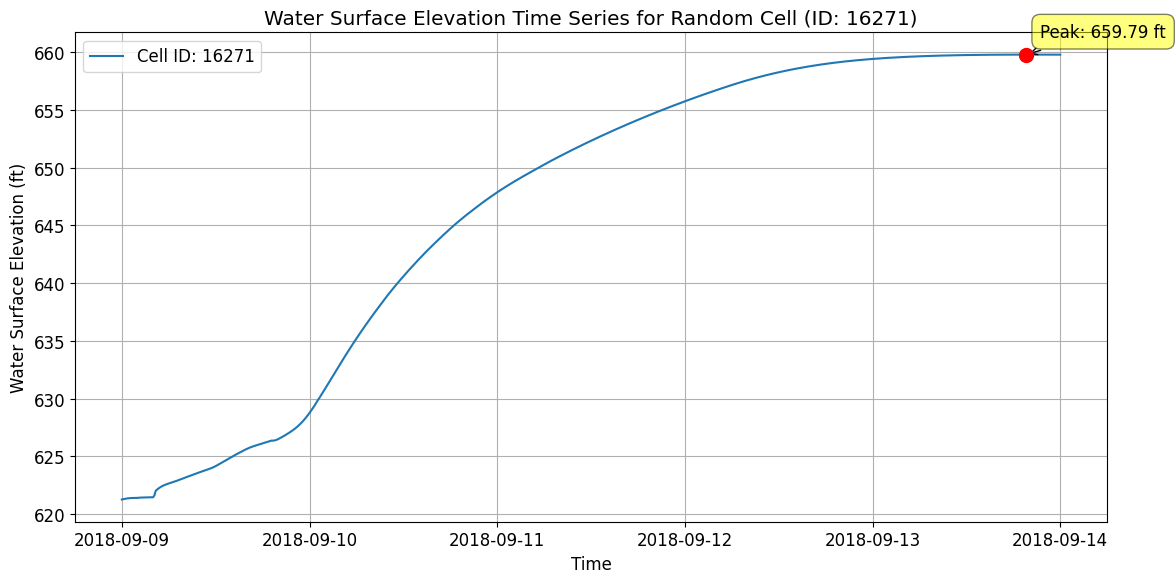

Statistics for Cell ID 16271:
Minimum WSEL: 621.27 ft
Maximum WSEL: 659.79 ft
Mean WSEL: 646.79 ft
Time of peak: 2018-09-13T19:40:00.000000000


In [59]:
# Plot WSE Time Series Data (Random Cell ID)
import matplotlib.pyplot as plt
import numpy as np
import random

# Extract Water Surface data
water_surface = cells_timeseries_ds['BaldEagleCr']['Water Surface']

# Get the time values
time_values = water_surface.coords['time'].values

# Pick a random cell_id
random_cell_id = random.choice(water_surface.coords['cell_id'].values)

# Extract the water surface elevation time series for the random cell
wsel_timeseries = water_surface.sel(cell_id=random_cell_id)

# Find the peak value and its index
peak_value = wsel_timeseries.max().item()
peak_index = wsel_timeseries.argmax().item()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(time_values, wsel_timeseries, label=f'Cell ID: {random_cell_id}')
plt.scatter(time_values[peak_index], peak_value, color='red', s=100, zorder=5)
plt.annotate(f'Peak: {peak_value:.2f} ft', 
             (time_values[peak_index], peak_value),
             xytext=(10, 10), textcoords='offset points',
             ha='left', va='bottom',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.title(f'Water Surface Elevation Time Series for Random Cell (ID: {random_cell_id})')
plt.xlabel('Time')
plt.ylabel('Water Surface Elevation (ft)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Log the plotting action
logging.info(f"Plotted water surface elevation time series for random cell ID: {random_cell_id}")

# Display the plot
plt.show()

# Print some statistics
print(f"Statistics for Cell ID {random_cell_id}:")
print(f"Minimum WSEL: {wsel_timeseries.min().item():.2f} ft")
print(f"Maximum WSEL: {peak_value:.2f} ft")
print(f"Mean WSEL: {wsel_timeseries.mean().item():.2f} ft")
print(f"Time of peak: {time_values[peak_index]}")

In [60]:
# Get mesh faces timeseries output
faces_timeseries_ds = HdfResultsMesh.get_mesh_faces_timeseries(plan_hdf_path, mesh_name)
print("\nMesh Faces Timeseries Output:")
print(faces_timeseries_ds)


2025-03-15 08:43:08 - ras_commander.HdfResultsMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:43:08 - ras_commander.HdfResultsMesh - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:43:09 - ras_commander.HdfResultsMesh - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf



Mesh Faces Timeseries Output:
<xarray.Dataset> Size: 217MB
Dimensions:        (time: 720, face_id: 37594)
Coordinates:
  * time           (time) datetime64[ns] 6kB 2018-09-09T00:10:00 ... 2018-09-14
  * face_id        (face_id) int64 301kB 0 1 2 3 4 ... 37590 37591 37592 37593
Data variables:
    face_velocity  (time, face_id) float32 108MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    face_flow      (time, face_id) float32 108MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    units:      ft/s
    mesh_name:  BaldEagleCr
    variable:   Face Velocity


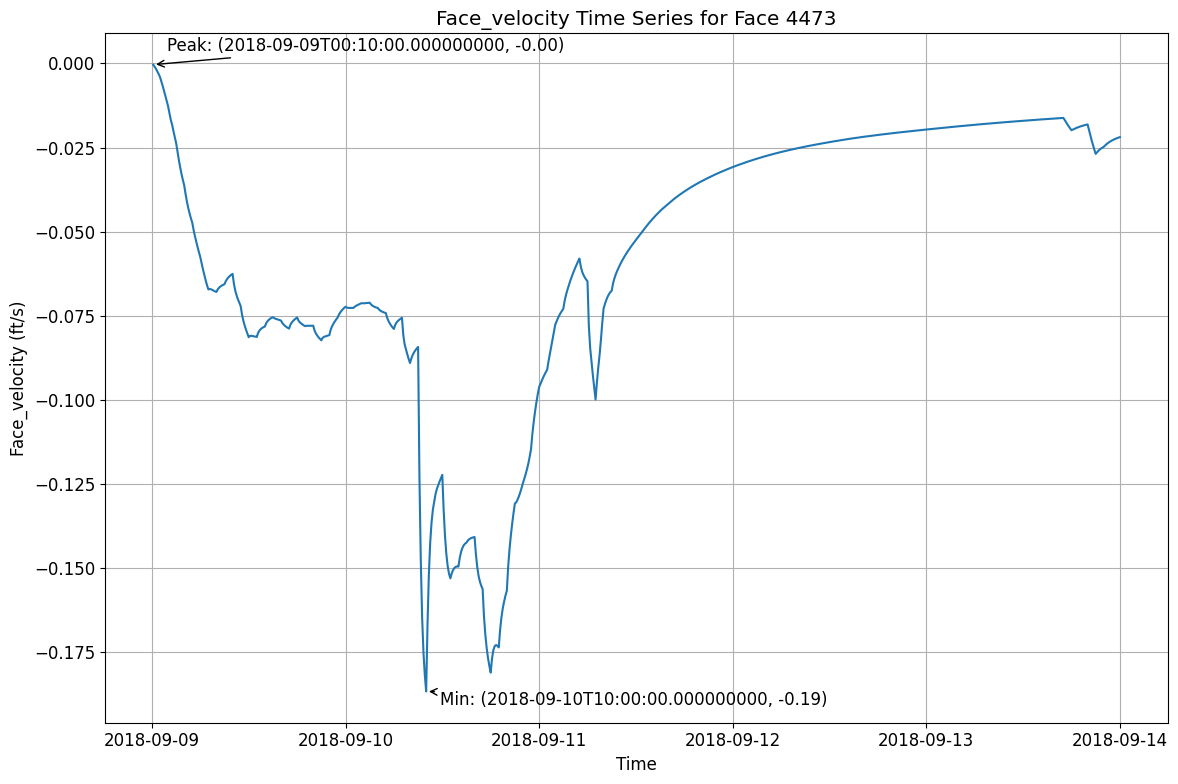

2025-03-15 08:43:10 - ras_commander.HdfMesh - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:43:10 - ras_commander.HdfMesh - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:43:11 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:43:11 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
C:\Users\billk\AppData\Local\Temp\ipykernel_19692\298266842.py:141: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


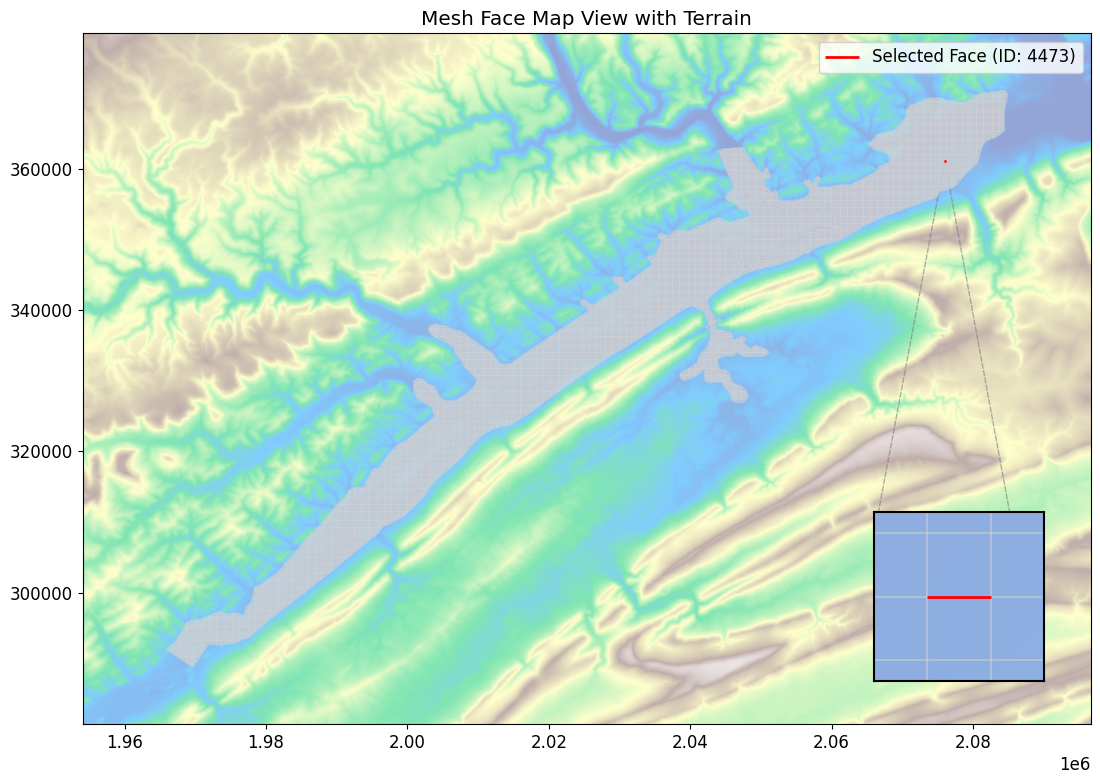

2025-03-15 08:43:49 - root - INFO - Plotted mesh face time series and map view for random face ID: 4473 with terrain


Random Face: 4473
Peak Value: -0.00 ft/s at 2018-09-09T00:10:00.000000000
Minimum Value: -0.19 ft/s at 2018-09-10T10:00:00.000000000


In [61]:
# Plot Random Face Results and Label Peak, Plus Map View

# Step 1: Import necessary libraries 
# In notebook cell at top of notebook

# Step 2: Select a random valid face ID number
random_face = np.random.randint(0, faces_timeseries_ds.sizes['face_id'])

# Step 3: Extract time series data for the selected face
variable = 'face_velocity'  # We could also use 'face_flow'
face_data = faces_timeseries_ds[variable].sel(face_id=random_face)

# Step 4: Find peak value and its corresponding time
peak_value = face_data.max().item()
peak_time = face_data.idxmax().values

# Plot time series
plt.figure(figsize=(12, 8))
plt.plot(faces_timeseries_ds.time, face_data)
plt.title(f'{variable.capitalize()} Time Series for Face {random_face}')
plt.xlabel('Time')
plt.ylabel(f'{variable.capitalize()} ({faces_timeseries_ds.attrs["units"]})')
plt.grid(True)

# Annotate the peak point
plt.annotate(f'Peak: ({peak_time}, {peak_value:.2f})', 
            (peak_time, peak_value),
            xytext=(10, 10), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"))

# Check for negative values and label the minimum if present
min_value = face_data.min().item()
if min_value < 0:
    min_time = face_data.idxmin().values
    plt.annotate(f'Min: ({min_time}, {min_value:.2f})', 
                (min_time, min_value),
                xytext=(10, -10), textcoords='offset points',
                arrowprops=dict(arrowstyle="->"))

plt.tight_layout()
plt.show()

# Create map view plot
fig, ax = plt.subplots(figsize=(12, 8))

# Get mesh faces for map view
mesh_faces = HdfMesh.get_mesh_cell_faces(plan_hdf_path)

# Calculate mesh faces extents with 10% buffer
faces_bounds = mesh_faces.total_bounds
x_min, y_min, x_max, y_max = faces_bounds
buffer_x = (x_max - x_min) * 0.1
buffer_y = (y_max - y_min) * 0.1
plot_xlim = [x_min - buffer_x, x_max + buffer_x]
plot_ylim = [y_min - buffer_y, y_max + buffer_y]

# Set plot limits before adding terrain
ax.set_xlim(plot_xlim)
ax.set_ylim(plot_ylim)

# Add the terrain TIFF to the map, clipped to our desired extent
tiff_path = Path.cwd() / 'example_projects' / 'BaldEagleCrkMulti2D' / 'Terrain' / 'Terrain50.baldeagledem.tif'
with rasterio.open(tiff_path) as src:
    show(src, ax=ax, cmap='terrain', alpha=0.5)
    
# Reset the limits after terrain plot
ax.set_xlim(plot_xlim)
ax.set_ylim(plot_ylim)

# Plot all faces in gray
mesh_faces.plot(ax=ax, color='lightgray', alpha=0.5, zorder=2)

# Get the selected face geometry
selected_face = mesh_faces[mesh_faces['face_id'] == random_face]

# Highlight the selected face in red
selected_face.plot(
    ax=ax, 
    color='red',
    linewidth=2,
    label=f'Selected Face (ID: {random_face})',
    zorder=3
)

# Get bounds of selected face for zoomed inset
bounds = selected_face.geometry.bounds.iloc[0]
x_center = (bounds.iloc[0] + bounds.iloc[2]) / 2
y_center = (bounds.iloc[1] + bounds.iloc[3]) / 2
buffer = max(bounds.iloc[2] - bounds.iloc[0], bounds.iloc[3] - bounds.iloc[1]) * 2

# Create zoomed inset with a larger size, inside the map frame
axins = inset_axes(ax, width="70%", height="70%", loc='lower right',
                  bbox_to_anchor=(0.65, 0.05, 0.35, 0.35),
                  bbox_transform=ax.transAxes)

# Plot terrain and faces in inset
with rasterio.open(tiff_path) as src:
    show(src, ax=axins, cmap='terrain', alpha=0.5)
    
# Plot zoomed view in inset
mesh_faces.plot(ax=axins, color='lightgray', alpha=0.5, zorder=2)
selected_face.plot(ax=axins, color='red', linewidth=2, zorder=3)

# Set inset limits with slightly more context
axins.set_xlim(x_center - buffer/1.5, x_center + buffer/1.5)
axins.set_ylim(y_center - buffer/1.5, y_center + buffer/1.5)

# Remove inset ticks for cleaner look
axins.set_xticks([])
axins.set_yticks([])

# Add a border to the inset
for spine in axins.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

# Create connection lines between main plot and inset
# Get the selected face centroid for connection point
centroid = selected_face.geometry.centroid.iloc[0]
con1 = ConnectionPatch(
    xyA=(centroid.x, centroid.y), coordsA=ax.transData,
    xyB=(0.02, 0.98), coordsB=axins.transAxes,
    arrowstyle="-", linestyle="--", color="gray", alpha=0.6
)
con2 = ConnectionPatch(
    xyA=(centroid.x, centroid.y), coordsA=ax.transData,
    xyB=(0.98, 0.02), coordsB=axins.transAxes,
    arrowstyle="-", linestyle="--", color="gray", alpha=0.6
)

ax.add_artist(con1)
ax.add_artist(con2)

# Add title and legend to main plot
ax.set_title('Mesh Face Map View with Terrain')
ax.legend()

# Ensure equal aspect ratio while maintaining our desired extents
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

# Print summary information
print(f"Random Face: {random_face}")
print(f"Peak Value: {peak_value:.2f} {faces_timeseries_ds.attrs['units']} at {peak_time}")
if min_value < 0:
    print(f"Minimum Value: {min_value:.2f} {faces_timeseries_ds.attrs['units']} at {min_time}")

# Log the plotting action
logging.info(f"Plotted mesh face time series and map view for random face ID: {random_face} with terrain")

In [62]:
# Get meteorology precipitation attributes
meteo_precip_attrs = HdfPlan.get_plan_met_precip(plan_hdf_path)
print("\nMeteorology Precipitation Attributes:")
for key, value in meteo_precip_attrs.items():
    print(f"{key}: {value}")

2025-03-15 08:43:49 - ras_commander.HdfPlan - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf



Meteorology Precipitation Attributes:
DSS Filename: .\Precipitation\precip.2018.09.dss
DSS Pathname: /SHG/MARFC/PRECIP/01SEP2018:0200/01SEP2018:0300/NEXRAD/
Data Type: per-cum
Interpolation Method: 
Mode: Gridded
Projection: PROJCS["USA_Contiguous_Albers_Equal_Area_Conic_USGS_version",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Raster Cellsize: 2000.0
Raster Cols: 515
Raster Left: 1096000.0
Raster Rows: 522
Raster Top: 2560000.0
Source: DSS
Units: in


In [63]:
# Get results unsteady attributes
results_unsteady_attrs = HdfResultsPlan.get_unsteady_info(plan_hdf_path)
print("\nResults Unsteady Attributes:")
for key, value in results_unsteady_attrs.items():
    print(f"{key}: {value}")

2025-03-15 08:43:49 - ras_commander.HdfResultsPlan - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf



Results Unsteady Attributes:
Plan Title: 0    b'Gridded Precip - Infiltration'
Name: Plan Title, dtype: object
Program Name: 0    b'HEC-RAS - River Analysis System'
Name: Program Name, dtype: object
Program Version: 0    b'HEC-RAS 6.6 September 2024'
Name: Program Version, dtype: object
Project File Name: 0    b'c:\\GH\\ras-commander\\examples\\example_pro...
Name: Project File Name, dtype: object
Project Title: 0    b'Bald Eagle Creek Example Dam Break Study'
Name: Project Title, dtype: object
Short ID: 0    b'Grid Precip Infiltration'
Name: Short ID, dtype: object
Simulation Time Window: 0    b'08Sep2018 2400 to 13Sep2018 2400'
Name: Simulation Time Window, dtype: object
Type of Run: 0    b'Unsteady Flow Analysis'
Name: Type of Run, dtype: object


In [64]:
# Get results unsteady summary attributes
results_unsteady_summary_attrs = HdfResultsPlan.get_unsteady_summary(plan_hdf_path)
print("\nResults Unsteady Summary Attributes:")
for key, value in results_unsteady_summary_attrs.items():
    print(f"{key}: {value}")

# Get results volume accounting attributes
volume_accounting_attrs = HdfResultsPlan.get_volume_accounting(plan_hdf_path)
print("\nVolume Accounting Attributes:")
for key, value in volume_accounting_attrs.items():
    print(f"{key}: {value}")

2025-03-15 08:43:50 - ras_commander.HdfResultsPlan - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf
2025-03-15 08:43:50 - ras_commander.HdfResultsPlan - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p06.hdf



Results Unsteady Summary Attributes:
Computation Time DSS: 0    b'00:00:00'
Name: Computation Time DSS, dtype: object
Computation Time Total: 0    b'00:07:29'
Name: Computation Time Total, dtype: object
Maximum WSEL Error: 0    0.0
Name: Maximum WSEL Error, dtype: float32
Maximum number of cores: 0    4
Name: Maximum number of cores, dtype: int32
Run Time Window: 0    b'15MAR2025 08:35:00 to 15MAR2025 08:42:28'
Name: Run Time Window, dtype: object
Solution: 0    b'Unsteady Finished Successfully'
Name: Solution, dtype: object
Time Solution Went Unstable: 0   NaN
Name: Time Solution Went Unstable, dtype: float32
Time Stamp Solution Went Unstable: 0    b'Not Applicable'
Name: Time Stamp Solution Went Unstable, dtype: object

Volume Accounting Attributes:
Error: 0    0.470055
Name: Error, dtype: float32
Error Percent: 0    0.000332
Name: Error Percent, dtype: float32
Precipitation Excess (acre feet): 0    3756.872803
Name: Precipitation Excess (acre feet), dtype: float32
Precipitation Exc